In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
torch.cuda.is_available()

True

In [3]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [4]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [5]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [3]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 50
        
        #cuda_enabled = torch.cuda.is_available()
        #if cuda_enabled:
        #    device = torch.device('cuda')
        #    self.batch_size = 25
        #else:
        #    device = torch.device('cpu')
        #    self.batch_size = 20

        #self.Bert.to(device)
        #print(f'We are running on device: {device}')
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
        
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
        
        #Check device
        device = self.Bert.device
        
        #Preprocess data
        X = X.str.replace('\n','')
        X = X.str.replace('\r','')
        X = X.str.lower()
        X = X.values.tolist()
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X, return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(len(X) / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size].to(device)
            
            inputs_batch
            outputs = self.Bert(**inputs_batch)
            #inputs = self.Tokenizer(X[batchId * self.batch_size:(batchId + 1) * self.batch_size].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
            #outputs = self.Bert(**inputs)
            #outputs = outputs['pooler_output'].detach().numpy()
            
            outputs = outputs['pooler_output'].to('cpu').detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [58]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
#Read the data

In [4]:
#Test data anonymized
#df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')
df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')

<ipython-input-4-01876a210620>:3: DtypeWarning: Columns (1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,41,43,45,47,49,51,52,54,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')


In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,CRMIncidentId,IncidentId,LineId,Linje,JourneyId,TurNummer,Trafikslag,Ankomstdag,...,Enhet,Queue_SK,Kö,ModifiedOn,ContactId,Contact_SK,iBID,IsActive,TicketId,Beskrivning_Anonymized
0,0,0,673326.0,77DE23B5-43D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-10-29 11:33:19,586769.0,C0BDFF48-2C0B-E811-80F1-005056B64D75,NaN,True,NaN,"Hej,\r\r\n \r\r\nHar nu fått tag i föraren som..."
1,1,1,673354.0,EBD68435-41D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 08:17:09,331145.0,E429FD9A-5DEC-E411-80D6-0050569071BE,NaN,True,NaN,Buss 000 00:00\r\r\n\r\r\nKristianstad Hästtor...
2,2,2,673617.0,3ED0AA37-16D9-E811-80F4-005056B62B18,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2021-10-07 08:49:10,726145.0,12F4B35F-16D9-E811-80F4-005056B62B18,NaN,True,NaN,Skadeanmälan för påkörning av bil bakifrån vid...
3,3,3,673807.0,AAA91AC9-E0D8-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 10:36:12,603794.0,56A30A33-A32D-E811-80F2-005056B62B18,NaN,True,NaN,"Hej, \r\r\nVarför heter en av hållplatserna i ..."
4,4,4,673850.0,5F1165E6-63D9-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2019-11-27 15:06:13,22229.0,383EAEB1-1DEB-E411-80D8-005056903A38,NaN,True,NaN,Hej!\r\r\nHar en fråga som gäller busskurerna ...


In [6]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CRMIncidentId', 'IncidentId', 'LineId',
       'Linje', 'JourneyId', 'TurNummer', 'Trafikslag', 'Ankomstdag',
       'Händelsedatum', 'Hanteratdatum', 'Ärendenummer', 'KategoriId11',
       'Kategori11', 'KategoriId12', 'Kategori12', 'KategoriId13',
       'Kategori13', 'KategoriId21', 'Kategori21', 'KategoriId22',
       'Kategori22', 'KategoriId23', 'Kategori23', 'KategoriId31',
       'Kategori31', 'KategoriId32', 'Kategori32', 'KategoriId33',
       'Kategori33', 'KategoriId41', 'Kategori41', 'KategoriId42',
       'Kategori42', 'KategoriId43', 'Kategori43', 'Titel', 'CaseType_SK',
       'Ärendetyp', 'CaseOrigin_SK', 'Ursprung', 'Priority_SK', 'Prioritet',
       'IncidentStage_SK', 'ÄrendeStatus', 'Owner_SK', 'Handläggare',
       'BusinessUnit_SK', 'Enhet', 'Queue_SK', 'Kö', 'ModifiedOn', 'ContactId',
       'Contact_SK', 'iBID', 'IsActive', 'TicketId', 'Beskrivning_Anonymized'],
      dtype='object')

In [7]:
#Remove nans, select relevant columns
df = df[['Ärendetyp', 'Beskrivning_Anonymized', 'Prioritet', 'Ankomstdag']]
df = df[~df['Ärendetyp'].isna()]
df = df[~df['Beskrivning_Anonymized'].isna()]

(array([288232.,  88707.,      0.,   5276.,      0., 160978., 799256.,
             0.,   6202.,   2816.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

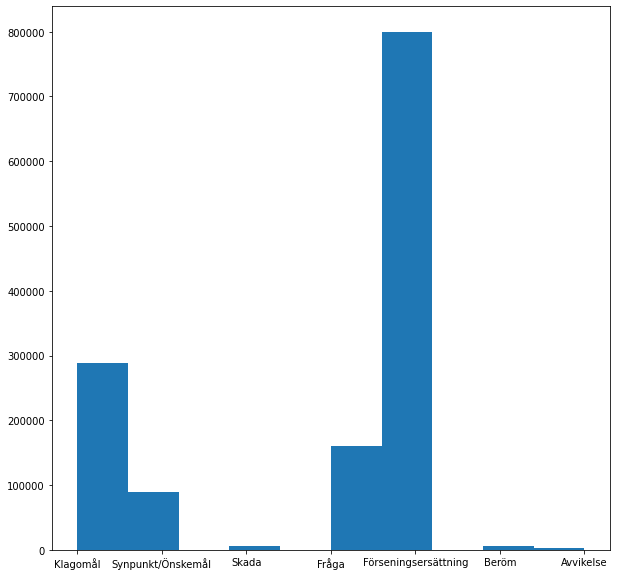

In [8]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [9]:
df['Ärendetyp'].value_counts()

Förseningsersättning    799256
Klagomål                288232
Fråga                   160978
Synpunkt/Önskemål        88707
Beröm                     6202
Skada                     5276
Avvikelse                 2816
Name: Ärendetyp, dtype: int64

In [10]:
df.shape

(1351467, 4)

In [11]:
categories = df['Ärendetyp'].unique()

In [12]:
categories

array(['Klagomål', 'Synpunkt/Önskemål', 'Skada', 'Fråga',
       'Förseningsersättning', 'Beröm', 'Avvikelse'], dtype=object)

In [13]:
#Make a balanced training set
desiredCount = 20000
#desiredCount = 1500
dfBalanced = None
for category in categories:
    sample = df[df['Ärendetyp'] == category].sample(n=desiredCount, replace=True, random_state=42)
    if dfBalanced is None:
        dfBalanced = sample
    else:
        dfBalanced = pd.concat([dfBalanced, sample], ignore_index=True)


#Next random shuffle of all rows
df = dfBalanced.sample(frac=1)

In [14]:
#df = df[:10000] #Max for this computer
df.shape

(140000, 4)

(array([20000., 20000.,     0., 20000.,     0., 20000., 20000.,     0.,
        20000., 20000.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

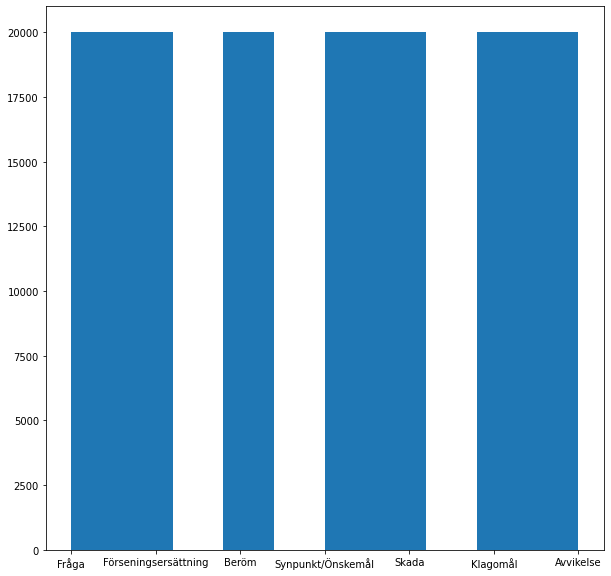

In [15]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [16]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary

In [17]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])

In [18]:
classes = Y.columns

In [19]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [20]:
Y.shape

(140000, 7)

In [21]:
transformer = NLPTransformer()

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
X.shape

(140000,)

In [25]:
Y.shape

(140000, 7)

In [23]:
Y.to_pickle('targets.pkl')

In [ ]:
X_transformed = transformer.transform(X)

Transform Called
Running batch 1/2800
output shape: (50, 768)
Running batch 2/2800
output shape: (50, 768)
Running batch 3/2800
output shape: (50, 768)
Running batch 4/2800
output shape: (50, 768)
Running batch 5/2800
output shape: (50, 768)
Running batch 6/2800
output shape: (50, 768)
Running batch 7/2800
output shape: (50, 768)
Running batch 8/2800
output shape: (50, 768)
Running batch 9/2800
output shape: (50, 768)
Running batch 10/2800
output shape: (50, 768)
Running batch 11/2800
output shape: (50, 768)
Running batch 12/2800
output shape: (50, 768)
Running batch 13/2800
output shape: (50, 768)
Running batch 14/2800
output shape: (50, 768)
Running batch 15/2800
output shape: (50, 768)
Running batch 16/2800
output shape: (50, 768)
Running batch 17/2800
output shape: (50, 768)
Running batch 18/2800
output shape: (50, 768)
Running batch 19/2800
output shape: (50, 768)
Running batch 20/2800
output shape: (50, 768)
Running batch 21/2800
output shape: (50, 768)
Running batch 22/2800
outp

output shape: (50, 768)
Running batch 178/2800
output shape: (50, 768)
Running batch 179/2800
output shape: (50, 768)
Running batch 180/2800
output shape: (50, 768)
Running batch 181/2800
output shape: (50, 768)
Running batch 182/2800
output shape: (50, 768)
Running batch 183/2800
output shape: (50, 768)
Running batch 184/2800
output shape: (50, 768)
Running batch 185/2800
output shape: (50, 768)
Running batch 186/2800
output shape: (50, 768)
Running batch 187/2800
output shape: (50, 768)
Running batch 188/2800
output shape: (50, 768)
Running batch 189/2800
output shape: (50, 768)
Running batch 190/2800
output shape: (50, 768)
Running batch 191/2800
output shape: (50, 768)
Running batch 192/2800
output shape: (50, 768)
Running batch 193/2800
output shape: (50, 768)
Running batch 194/2800
output shape: (50, 768)
Running batch 195/2800
output shape: (50, 768)
Running batch 196/2800
output shape: (50, 768)
Running batch 197/2800
output shape: (50, 768)
Running batch 198/2800
output shape:

output shape: (50, 768)
Running batch 353/2800
output shape: (50, 768)
Running batch 354/2800
output shape: (50, 768)
Running batch 355/2800
output shape: (50, 768)
Running batch 356/2800
output shape: (50, 768)
Running batch 357/2800
output shape: (50, 768)
Running batch 358/2800
output shape: (50, 768)
Running batch 359/2800
output shape: (50, 768)
Running batch 360/2800
output shape: (50, 768)
Running batch 361/2800
output shape: (50, 768)
Running batch 362/2800
output shape: (50, 768)
Running batch 363/2800
output shape: (50, 768)
Running batch 364/2800
output shape: (50, 768)
Running batch 365/2800
output shape: (50, 768)
Running batch 366/2800
output shape: (50, 768)
Running batch 367/2800
output shape: (50, 768)
Running batch 368/2800
output shape: (50, 768)
Running batch 369/2800
output shape: (50, 768)
Running batch 370/2800
output shape: (50, 768)
Running batch 371/2800
output shape: (50, 768)
Running batch 372/2800
output shape: (50, 768)
Running batch 373/2800
output shape:

In [ ]:
X_transformed.shape

In [ ]:
np.save('transformed_data.pkl', X_transformed)

In [11]:
#Note in case of pytorch CrossEntropyLoss, the targets should be the class index, not one hot encoded
Y = Y.values.argmax(axis=1)


In [21]:
Y

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
28,0,0,0,0,1,0,0
286,0,0,0,0,0,0,1
853,0,1,0,0,0,0,0
278,0,0,0,0,0,0,1
35,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
480,0,0,1,0,0,0,0
49,0,0,0,0,1,0,0
499,0,0,1,0,0,0,0
74,0,0,0,0,1,0,0


In [13]:
Y.max()

6

In [62]:
#This could also be a target
Y2 = pd.get_dummies(df['Prioritet'], columns=['Prioritet'])

In [63]:
Y2.head()

,Hög,Normal
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [21]:
X.head()

0    hej,\r\n \r\nhar nu fått tag i föraren som är ...
1    buss 000 00:00\r\n\r\nkristianstad hästtorget ...
2    skadeanmälan för påkörning av bil bakifrån vid...
3    hej, \r\nvarför heter en av hållplatserna i lu...
4    hej!\r\nhar en fråga som gäller busskurerna i ...
Name: Beskrivning_Anonymized, dtype: object

In [22]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [23]:
Y.head()

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [24]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [25]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [57]:
X_train.shape

(8400,)

In [24]:
Y_train[:5]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
935,1,0,0,0,0,0,0
1009,1,0,0,0,0,0,0
262,0,0,0,0,0,0,1
931,1,0,0,0,0,0,0
814,0,1,0,0,0,0,0


In [25]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100, max_epochs=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.batchId = 0
        self.epochId = 0
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1
            #print(self.batchId, self.epochId)
            #print(len(X_mini))
            if len(X_mini) < self.batch_size:
                self.epochId += 1
                self.batchId = 0
                if self.epochId <= self.max_epochs:
                    #print('will break')
                    break
            
            yield X_mini, Y_mini
            
    def getBatchInfo(self):
        return f'batch: {self.batchId}/{int(np.ceil(self.X.shape[0] / self.batch_size))}'

In [30]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [59]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/168
output shape: (50, 768)
Running batch 2/168
output shape: (50, 768)
Running batch 3/168
output shape: (50, 768)
Running batch 4/168
output shape: (50, 768)
Running batch 5/168
output shape: (50, 768)
Running batch 6/168
output shape: (50, 768)
Running batch 7/168
output shape: (50, 768)
Running batch 8/168
output shape: (50, 768)
Running batch 9/168
output shape: (50, 768)
Running batch 10/168
output shape: (50, 768)
Running batch 11/168
output shape: (50, 768)
Running batch 12/168
output shape: (50, 768)
Running batch 13/168
output shape: (50, 768)
Running batch 14/168
output shape: (50, 768)
Running batch 15/168
output shape: (50, 768)
Running batch 16/168
output shape: (50, 768)
Running batch 17/168
output shape: (50, 768)
Running batch 18/168
output shape: (50, 768)
Running batch 19/168
output shape: (50, 768)
Running batch 20/168
output shape: (50, 768)
Running batch 21/168
output shape: (50, 768)
Running batch 22/168
output shape: (

In [ ]:
output.predict(X_test[:10])

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
521,0,0,1,0,0,0,0
941,0,0,0,0,0,0,1
741,0,0,1,0,0,0,0
980,0,0,0,0,0,0,1
411,0,0,0,0,0,0,1
679,0,0,1,0,0,0,0
673,0,0,0,0,0,0,1
513,0,0,0,0,1,0,0
773,0,0,0,0,1,0,0
136,0,0,0,0,0,0,1


In [33]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [31]:
result = PredictClasses(pipeline, X_test[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


In [29]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2], dtype=int64)

In [32]:
Y_test[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
2750,0,0,0,1,0,0,0
7487,0,0,0,1,0,0,0
5272,0,0,0,1,0,0,0
5653,0,0,0,1,0,0,0
3999,0,0,0,1,0,0,0
6033,0,0,0,1,0,0,0
582,0,0,0,0,1,0,0
9930,0,0,0,1,0,0,0
7051,0,0,0,1,0,0,0
8158,0,0,0,1,0,0,0


In [38]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 3], dtype=int64)

In [41]:
ost = Y_test[10:20].to_numpy().argmax(axis=1)
ost

array([3, 3, 3, 3, 3, 3, 4, 3, 3, 3], dtype=int64)

In [51]:
result.shape

(10,)

In [77]:
cm = confusion_matrix(ost, result,normalize='true')
cm

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

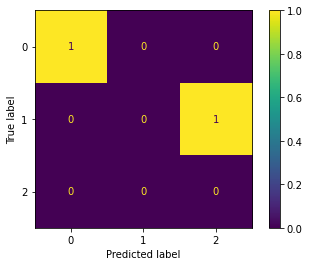

In [78]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot()

In [61]:
confusion_matrix(ost, result)

array([[9, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int64)

In [62]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/200


KeyboardInterrupt: 

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [37]:
Y_test.columns

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [41]:
Y_test.columns.shape

(7,)

In [45]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    #cm = confusion_matrix(targets, Y_pred, normalize='true')
    #ConfusionMatrixDisplay(confusion_matrix=cm,).plot()
    cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(range(Y_test.columns.shape[0])))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(Y_test.columns.shape[0]))).plot()
    

In [35]:
#Evaluate the model and print the accuracy

def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

Transform Called
Running batch 1/42
output shape: (50, 768)
Running batch 2/42
output shape: (50, 768)
Running batch 3/42
output shape: (50, 768)
Running batch 4/42
output shape: (50, 768)
Running batch 5/42
output shape: (50, 768)
Running batch 6/42
output shape: (50, 768)
Running batch 7/42
output shape: (50, 768)
Running batch 8/42
output shape: (50, 768)
Running batch 9/42
output shape: (50, 768)
Running batch 10/42
output shape: (50, 768)
Running batch 11/42
output shape: (50, 768)
Running batch 12/42
output shape: (50, 768)
Running batch 13/42
output shape: (50, 768)
Running batch 14/42
output shape: (50, 768)
Running batch 15/42
output shape: (50, 768)
Running batch 16/42
output shape: (50, 768)
Running batch 17/42
output shape: (50, 768)
Running batch 18/42
output shape: (50, 768)
Running batch 19/42
output shape: (50, 768)
Running batch 20/42
output shape: (50, 768)
Running batch 21/42
output shape: (50, 768)
Running batch 22/42
output shape: (50, 768)
Running batch 23/42
outp

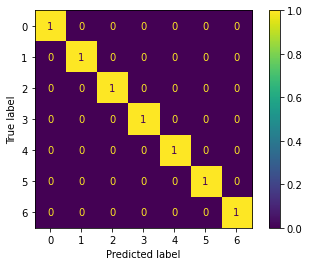

In [60]:
EvaluateModelUsingProbs(pipeline, X_test, Y_test)

In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [104]:
X[:2].values

array(['hej,\r\r\n \r\r\nhar nu fått tag i föraren som är i grekland på semester.\r\r\n \r\r\nden unga killen som frågade fick svaret av föraren att det är läge xxxx som gäller på knutpunkten.\r\r\n\r\r\ndetta gav föraren resenären efter att ha själv letat upp det på skånetrafikens app.\r\r\nmotparten lämnar tyvärr en del information till sin egen fördel.\r\r\nföraren försökte att hjälpa så gott han kunde.\r\r\n \r\r\n\r\r\nmed vänlig hälsning,\r\r\n  xxxx prata\r\r\n\r\r\ngruppchef\r\r\n \r\r\nnobina sverige ab\r\r\n\r\r\nadress: streetname_replaced 00, 000 00 helsingborg\r\r\nmobil:  +00 00 000 00 00\r\r\ndirekt: +00 0 000 000 00\r\r\n\r\r\nväxel:  +00 0 000 000 00\r\r\n\r\r\nhemsida:\r\r\nwww.nobina.com\r\r\n \r\r\nnobina sverige ab, org.nr 000000-0000 | styrelsens säte - stockholm\r\r\n\r\r\np please consider the environment before printing this e-mail.\r\r\n\r\r\n \r\r\n\r\r\nfrån: xxxx prata \r\r\n\r\r\nskickat: den 00 oktober 0000 00:00\r\r\n\r\r\ntill: email@address.replaced em

In [94]:
inputs = X[]

In [95]:
inputs

0    jag vill ha ersättning för min biljett, då tåg...
1                      bussen hade dålig air condition
2    beskrivning i avic:\r\r\n xxxx sjukresebeställ...
dtype: object

In [107]:
PredictClasses(pipeline, X[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([6, 1, 4, 4, 6, 6, 4, 2, 5, 0], dtype=int64)

In [108]:
Y[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
10,0,0,1,0,0,0,0
11,0,0,0,0,0,0,1
12,0,0,0,0,0,0,1
13,0,0,0,0,0,0,1
14,0,0,0,0,0,0,1
15,0,0,0,0,1,0,0
16,0,0,0,0,1,0,0
17,0,0,1,0,0,0,0
18,0,0,0,0,1,0,0
19,0,0,0,0,1,0,0


In [140]:
#Save, Load model

In [61]:
from joblib import dump, load

In [62]:
modelName = 'BertModel.joblib'

In [63]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [15]:
from torch import nn, optim
import torch.nn.functional as F

class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 256),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.42),              
                          nn.Linear(128, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        #print('Forward Called')
       
        #Check device
        device = self.Bert.device
        
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
        
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = self.forward(X)
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            self.train()
            return top_class

In [48]:
Y.max()

6

In [49]:
#n_classes = Y.shape[1] #In case of one hot encoded, which we don't have anymore
n_classes = Y.max() + 1
torchModel = TorchNLP(n_classes = n_classes)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
output = torchModel(X_train[:5])

Forward Called


In [68]:
output

tensor([[0.1394, 0.1599, 0.1548, 0.1324, 0.1248, 0.1408, 0.1479],
        [0.1428, 0.1565, 0.1440, 0.1306, 0.1277, 0.1471, 0.1513],
        [0.1410, 0.1569, 0.1521, 0.1396, 0.1235, 0.1379, 0.1489],
        [0.1318, 0.1499, 0.1585, 0.1312, 0.1373, 0.1510, 0.1404],
        [0.1423, 0.1517, 0.1463, 0.1242, 0.1348, 0.1532, 0.1476]],
       grad_fn=<SoftmaxBackward0>)

In [50]:
#mMiniBatcherTrain = MiniBatcher(X_train[:1000], Y_train[:1000], batch_size=15)
#mMiniBatcherTest = MiniBatcher(X_test[:100], Y_test[:100], batch_size=15)
mMiniBatcherTrain = MiniBatcher(X_train, Y_train, batch_size=100)
mMiniBatcherTest = MiniBatcher(X_test[:500], Y_test[:500], batch_size=100)

In [70]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [53]:
cuda_enabled = torch.cuda.is_available()
if cuda_enabled:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'We are running on device: {device}')

We are running on device: cuda


In [51]:
import gc

gc.collect()
torch.cuda.empty_cache() 

In [294]:
!pip install numba

In [30]:
#!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [32]:
#free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 | 19% | 100% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 25% |  8% |


In [54]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModel.parameters(), lr=0.003)
#optimizer = optim.Adam(torchModel.parameters(), lr=0.0015)
optimizer = optim.Adam(torchModel.TorchModel.parameters(), lr=0.0015)

epochs = 15
steps = 0
train_losses, test_losses = [], []

torchModel.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    print(f'Running epoch {e+1}/{epochs}')
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        #print('Training batch...')
        optimizer.zero_grad()
 
        #print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        
        #print('Running torch')
        output = torchModel(images)
        
        #print(f'output.shape: {output.shape}')
        #print('Calculating loss')
        
        loss = criterion(output, labels)
        #print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss} {mMiniBatcherTrain.getBatchInfo()}')
        running_loss += batch_loss
        
        del labels
        del images
        del output
        gc.collect()
        torch.cuda.empty_cache() 
   
    test_loss = 0
    accuracy = 0

    print('Running evaluation loop...')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            #print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            output = torchModel(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            #print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')
            print(mMiniBatcherTest.getBatchInfo())
            
            del labels
            del images
            del output
            gc.collect()
            torch.cuda.empty_cache() 

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(train_losses[-1]),
          "Test Loss: {:.5f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.5f}".format(accuracy/len(mMiniBatcherTest.X)))

Running epoch 1/15
Batch loss: 1.954135537147522 batch: 1/840
Batch loss: 1.9362761974334717 batch: 2/840
Batch loss: 1.8906426429748535 batch: 3/840
Batch loss: 1.8690556287765503 batch: 4/840
Batch loss: 1.8202908039093018 batch: 5/840
Batch loss: 1.835722804069519 batch: 6/840
Batch loss: 1.8324123620986938 batch: 7/840
Batch loss: 1.763242244720459 batch: 8/840
Batch loss: 1.6997215747833252 batch: 9/840
Batch loss: 1.6596179008483887 batch: 10/840
Batch loss: 1.5897629261016846 batch: 11/840
Batch loss: 1.539951205253601 batch: 12/840
Batch loss: 1.4772002696990967 batch: 13/840
Batch loss: 1.5468162298202515 batch: 14/840
Batch loss: 1.5089606046676636 batch: 15/840
Batch loss: 1.3836619853973389 batch: 16/840
Batch loss: 1.4789026975631714 batch: 17/840
Batch loss: 1.3889561891555786 batch: 18/840
Batch loss: 1.5200637578964233 batch: 19/840
Batch loss: 1.5299617052078247 batch: 20/840
Batch loss: 1.3485318422317505 batch: 21/840
Batch loss: 1.2940984964370728 batch: 22/840
Batc

Batch loss: 0.7951816320419312 batch: 182/840
Batch loss: 0.8690511584281921 batch: 183/840
Batch loss: 0.7038179039955139 batch: 184/840
Batch loss: 0.6490274667739868 batch: 185/840
Batch loss: 0.6118298172950745 batch: 186/840
Batch loss: 0.899085283279419 batch: 187/840
Batch loss: 0.6294940710067749 batch: 188/840
Batch loss: 0.7716383934020996 batch: 189/840
Batch loss: 0.8323737978935242 batch: 190/840
Batch loss: 0.9039003252983093 batch: 191/840
Batch loss: 0.6373999118804932 batch: 192/840
Batch loss: 0.7699265480041504 batch: 193/840
Batch loss: 0.6271510720252991 batch: 194/840
Batch loss: 0.8850708603858948 batch: 195/840
Batch loss: 0.8654938340187073 batch: 196/840
Batch loss: 0.9021247029304504 batch: 197/840
Batch loss: 0.6622282266616821 batch: 198/840
Batch loss: 0.6796248555183411 batch: 199/840
Batch loss: 1.0166761875152588 batch: 200/840
Batch loss: 0.7078800797462463 batch: 201/840
Batch loss: 0.7737282514572144 batch: 202/840
Batch loss: 0.730421781539917 batch

Batch loss: 0.8427690863609314 batch: 361/840
Batch loss: 0.7094565033912659 batch: 362/840
Batch loss: 0.6792579889297485 batch: 363/840
Batch loss: 0.8090555667877197 batch: 364/840
Batch loss: 0.6996357440948486 batch: 365/840
Batch loss: 0.7451508045196533 batch: 366/840
Batch loss: 0.6123248934745789 batch: 367/840
Batch loss: 0.8089743256568909 batch: 368/840
Batch loss: 0.7570825815200806 batch: 369/840
Batch loss: 0.844102680683136 batch: 370/840
Batch loss: 0.7829903364181519 batch: 371/840
Batch loss: 0.5819993615150452 batch: 372/840
Batch loss: 0.7638490200042725 batch: 373/840
Batch loss: 0.7978590130805969 batch: 374/840
Batch loss: 0.5898246169090271 batch: 375/840
Batch loss: 0.6014736890792847 batch: 376/840
Batch loss: 0.8016733527183533 batch: 377/840
Batch loss: 0.6976556181907654 batch: 378/840
Batch loss: 0.6751377582550049 batch: 379/840
Batch loss: 0.8054524064064026 batch: 380/840
Batch loss: 0.9623992443084717 batch: 381/840
Batch loss: 0.9835478067398071 batc

Batch loss: 0.9284355044364929 batch: 540/840
Batch loss: 0.6596453189849854 batch: 541/840
Batch loss: 0.7162241339683533 batch: 542/840
Batch loss: 0.4929408133029938 batch: 543/840
Batch loss: 0.7537846565246582 batch: 544/840
Batch loss: 0.6873822212219238 batch: 545/840
Batch loss: 0.6991969347000122 batch: 546/840
Batch loss: 0.6705578565597534 batch: 547/840
Batch loss: 0.5631430149078369 batch: 548/840
Batch loss: 0.6281132102012634 batch: 549/840
Batch loss: 0.5886301398277283 batch: 550/840
Batch loss: 0.7284570932388306 batch: 551/840
Batch loss: 0.5658173561096191 batch: 552/840
Batch loss: 0.7600362300872803 batch: 553/840
Batch loss: 0.7598035335540771 batch: 554/840
Batch loss: 0.757946789264679 batch: 555/840
Batch loss: 0.7470917701721191 batch: 556/840
Batch loss: 0.7330151200294495 batch: 557/840
Batch loss: 0.6981569528579712 batch: 558/840
Batch loss: 0.7330963611602783 batch: 559/840
Batch loss: 0.7011208534240723 batch: 560/840
Batch loss: 0.7255317568778992 batc

Batch loss: 0.4618542790412903 batch: 719/840
Batch loss: 0.6074709892272949 batch: 720/840
Batch loss: 0.7665508985519409 batch: 721/840
Batch loss: 0.8022251129150391 batch: 722/840
Batch loss: 0.6108312010765076 batch: 723/840
Batch loss: 0.8637728691101074 batch: 724/840
Batch loss: 0.6542158722877502 batch: 725/840
Batch loss: 0.6007346510887146 batch: 726/840
Batch loss: 0.9786267876625061 batch: 727/840
Batch loss: 0.7840850353240967 batch: 728/840
Batch loss: 0.7231331467628479 batch: 729/840
Batch loss: 0.6894960999488831 batch: 730/840
Batch loss: 0.5432916879653931 batch: 731/840
Batch loss: 0.8383905291557312 batch: 732/840
Batch loss: 0.6988280415534973 batch: 733/840
Batch loss: 0.6126189231872559 batch: 734/840
Batch loss: 0.6437366604804993 batch: 735/840
Batch loss: 0.7362656593322754 batch: 736/840
Batch loss: 0.6232479810714722 batch: 737/840
Batch loss: 0.5787289142608643 batch: 738/840
Batch loss: 0.8120728135108948 batch: 739/840
Batch loss: 0.7618032693862915 bat

Batch loss: 0.7629560232162476 batch: 55/840
Batch loss: 0.7648380994796753 batch: 56/840
Batch loss: 0.6573198437690735 batch: 57/840
Batch loss: 0.6300498843193054 batch: 58/840
Batch loss: 0.7975641489028931 batch: 59/840
Batch loss: 0.6121431589126587 batch: 60/840
Batch loss: 0.9078845977783203 batch: 61/840
Batch loss: 0.8052216172218323 batch: 62/840
Batch loss: 0.7341633439064026 batch: 63/840
Batch loss: 0.8013801574707031 batch: 64/840
Batch loss: 0.6917120218276978 batch: 65/840
Batch loss: 0.7406668066978455 batch: 66/840
Batch loss: 0.8201132416725159 batch: 67/840
Batch loss: 0.6787261962890625 batch: 68/840
Batch loss: 0.7875643968582153 batch: 69/840
Batch loss: 0.7249207496643066 batch: 70/840
Batch loss: 0.8109495639801025 batch: 71/840
Batch loss: 0.7322428822517395 batch: 72/840
Batch loss: 0.8322797417640686 batch: 73/840
Batch loss: 0.7041040658950806 batch: 74/840
Batch loss: 0.7945618629455566 batch: 75/840
Batch loss: 0.4904438853263855 batch: 76/840
Batch loss

Batch loss: 0.7729421257972717 batch: 235/840
Batch loss: 0.7577117681503296 batch: 236/840
Batch loss: 0.5641129612922668 batch: 237/840
Batch loss: 0.7865288257598877 batch: 238/840
Batch loss: 0.7301586866378784 batch: 239/840
Batch loss: 0.7609365582466125 batch: 240/840
Batch loss: 0.8113994598388672 batch: 241/840
Batch loss: 0.6313235759735107 batch: 242/840
Batch loss: 0.5920937657356262 batch: 243/840
Batch loss: 0.785841703414917 batch: 244/840
Batch loss: 0.5799567699432373 batch: 245/840
Batch loss: 0.7028455138206482 batch: 246/840
Batch loss: 0.6982203722000122 batch: 247/840
Batch loss: 0.7640137672424316 batch: 248/840
Batch loss: 0.9223235249519348 batch: 249/840
Batch loss: 0.6225365996360779 batch: 250/840
Batch loss: 0.694206714630127 batch: 251/840
Batch loss: 0.6365183591842651 batch: 252/840
Batch loss: 0.7373077273368835 batch: 253/840
Batch loss: 0.9442362785339355 batch: 254/840
Batch loss: 0.7323944568634033 batch: 255/840
Batch loss: 0.7443397641181946 batch

Batch loss: 0.702406644821167 batch: 414/840
Batch loss: 0.9646587371826172 batch: 415/840
Batch loss: 0.5132680535316467 batch: 416/840
Batch loss: 0.7814856767654419 batch: 417/840
Batch loss: 0.8084311485290527 batch: 418/840
Batch loss: 0.8190696239471436 batch: 419/840
Batch loss: 0.710356593132019 batch: 420/840
Batch loss: 0.6220932602882385 batch: 421/840
Batch loss: 0.6323842406272888 batch: 422/840
Batch loss: 0.8008817434310913 batch: 423/840
Batch loss: 0.7588991522789001 batch: 424/840
Batch loss: 0.7628356218338013 batch: 425/840
Batch loss: 0.7265452742576599 batch: 426/840
Batch loss: 0.717620313167572 batch: 427/840
Batch loss: 0.8238585591316223 batch: 428/840
Batch loss: 0.6396276354789734 batch: 429/840
Batch loss: 0.9030716419219971 batch: 430/840
Batch loss: 0.6654850244522095 batch: 431/840
Batch loss: 0.7328319549560547 batch: 432/840
Batch loss: 0.6005955338478088 batch: 433/840
Batch loss: 0.6661014556884766 batch: 434/840
Batch loss: 0.8167585134506226 batch:

Batch loss: 0.7742642760276794 batch: 593/840
Batch loss: 0.6991603374481201 batch: 594/840
Batch loss: 0.45113399624824524 batch: 595/840
Batch loss: 0.591407835483551 batch: 596/840
Batch loss: 0.7118915319442749 batch: 597/840
Batch loss: 0.5601863265037537 batch: 598/840
Batch loss: 0.5582578182220459 batch: 599/840
Batch loss: 0.8223369717597961 batch: 600/840
Batch loss: 0.7205594778060913 batch: 601/840
Batch loss: 0.6125538349151611 batch: 602/840
Batch loss: 0.7006803750991821 batch: 603/840
Batch loss: 0.7223252058029175 batch: 604/840
Batch loss: 0.9176857471466064 batch: 605/840
Batch loss: 0.8329961895942688 batch: 606/840
Batch loss: 0.7359417080879211 batch: 607/840
Batch loss: 0.8659982085227966 batch: 608/840
Batch loss: 0.6168786883354187 batch: 609/840
Batch loss: 0.7695086002349854 batch: 610/840
Batch loss: 0.7614015936851501 batch: 611/840
Batch loss: 0.8142792582511902 batch: 612/840
Batch loss: 0.7714126706123352 batch: 613/840
Batch loss: 0.7432668805122375 bat

Batch loss: 0.7136338949203491 batch: 772/840
Batch loss: 0.5603766441345215 batch: 773/840
Batch loss: 0.520460307598114 batch: 774/840
Batch loss: 0.54917311668396 batch: 775/840
Batch loss: 0.5805213451385498 batch: 776/840
Batch loss: 0.6006617546081543 batch: 777/840
Batch loss: 0.5212373733520508 batch: 778/840
Batch loss: 0.8456566333770752 batch: 779/840
Batch loss: 0.726939857006073 batch: 780/840
Batch loss: 0.7831668257713318 batch: 781/840
Batch loss: 0.6716859340667725 batch: 782/840
Batch loss: 0.5151993632316589 batch: 783/840
Batch loss: 0.7599252462387085 batch: 784/840
Batch loss: 0.7033916711807251 batch: 785/840
Batch loss: 0.7887646555900574 batch: 786/840
Batch loss: 0.6017487049102783 batch: 787/840
Batch loss: 0.7289230227470398 batch: 788/840
Batch loss: 0.8354370594024658 batch: 789/840
Batch loss: 0.7312440276145935 batch: 790/840
Batch loss: 0.6571652889251709 batch: 791/840
Batch loss: 0.5245264172554016 batch: 792/840
Batch loss: 0.6717785000801086 batch: 

Batch loss: 0.6759828925132751 batch: 109/840
Batch loss: 0.5473222136497498 batch: 110/840
Batch loss: 0.5582352876663208 batch: 111/840
Batch loss: 0.7974791526794434 batch: 112/840
Batch loss: 0.7353047132492065 batch: 113/840
Batch loss: 0.6366559863090515 batch: 114/840
Batch loss: 0.6948081851005554 batch: 115/840
Batch loss: 0.6145722270011902 batch: 116/840
Batch loss: 0.6543692946434021 batch: 117/840
Batch loss: 0.5518554449081421 batch: 118/840
Batch loss: 0.6531992554664612 batch: 119/840
Batch loss: 0.6035178899765015 batch: 120/840
Batch loss: 0.7630844712257385 batch: 121/840
Batch loss: 1.0080513954162598 batch: 122/840
Batch loss: 0.5163282155990601 batch: 123/840
Batch loss: 0.6124362349510193 batch: 124/840
Batch loss: 0.7135162353515625 batch: 125/840
Batch loss: 0.7433531880378723 batch: 126/840
Batch loss: 0.879401683807373 batch: 127/840
Batch loss: 0.7361404895782471 batch: 128/840
Batch loss: 0.777320921421051 batch: 129/840
Batch loss: 0.7002102732658386 batch

Batch loss: 0.5904445052146912 batch: 288/840
Batch loss: 0.8545376062393188 batch: 289/840
Batch loss: 0.7372949719429016 batch: 290/840
Batch loss: 0.7338487505912781 batch: 291/840
Batch loss: 0.587815523147583 batch: 292/840
Batch loss: 0.8504446148872375 batch: 293/840
Batch loss: 0.644611120223999 batch: 294/840
Batch loss: 0.4997488856315613 batch: 295/840
Batch loss: 0.6419566869735718 batch: 296/840
Batch loss: 0.7463201284408569 batch: 297/840
Batch loss: 0.6318334341049194 batch: 298/840
Batch loss: 0.6352393627166748 batch: 299/840
Batch loss: 0.8721566200256348 batch: 300/840
Batch loss: 0.7264401316642761 batch: 301/840
Batch loss: 0.6743545532226562 batch: 302/840
Batch loss: 0.7715914845466614 batch: 303/840
Batch loss: 0.6067880988121033 batch: 304/840
Batch loss: 0.6194544434547424 batch: 305/840
Batch loss: 0.7523966431617737 batch: 306/840
Batch loss: 0.599102258682251 batch: 307/840
Batch loss: 0.8265693187713623 batch: 308/840
Batch loss: 0.660824716091156 batch: 

Batch loss: 0.9584640264511108 batch: 467/840
Batch loss: 0.6751030683517456 batch: 468/840
Batch loss: 0.5632038116455078 batch: 469/840
Batch loss: 0.6779122948646545 batch: 470/840
Batch loss: 0.6806524395942688 batch: 471/840
Batch loss: 0.7061455249786377 batch: 472/840
Batch loss: 0.8148102760314941 batch: 473/840
Batch loss: 0.6753948330879211 batch: 474/840
Batch loss: 0.7666313648223877 batch: 475/840
Batch loss: 0.6829323768615723 batch: 476/840
Batch loss: 0.5460050702095032 batch: 477/840
Batch loss: 0.5037806034088135 batch: 478/840
Batch loss: 0.5709492564201355 batch: 479/840
Batch loss: 0.6975857615470886 batch: 480/840
Batch loss: 0.6135264039039612 batch: 481/840
Batch loss: 0.7064226269721985 batch: 482/840
Batch loss: 0.8125025033950806 batch: 483/840
Batch loss: 0.6295955181121826 batch: 484/840
Batch loss: 0.7056680917739868 batch: 485/840
Batch loss: 0.65228271484375 batch: 486/840
Batch loss: 0.5058897137641907 batch: 487/840
Batch loss: 0.6829477548599243 batch

Batch loss: 0.6532209515571594 batch: 646/840
Batch loss: 0.789581298828125 batch: 647/840
Batch loss: 0.6360241770744324 batch: 648/840
Batch loss: 0.646595299243927 batch: 649/840
Batch loss: 0.5973663926124573 batch: 650/840
Batch loss: 0.712001621723175 batch: 651/840
Batch loss: 0.7650576233863831 batch: 652/840
Batch loss: 0.6351963877677917 batch: 653/840
Batch loss: 0.878908634185791 batch: 654/840
Batch loss: 0.6146227717399597 batch: 655/840
Batch loss: 0.633087158203125 batch: 656/840
Batch loss: 0.6378815174102783 batch: 657/840
Batch loss: 0.7844903469085693 batch: 658/840
Batch loss: 0.8119395971298218 batch: 659/840
Batch loss: 0.49511516094207764 batch: 660/840
Batch loss: 0.7709668874740601 batch: 661/840
Batch loss: 0.7787835001945496 batch: 662/840
Batch loss: 0.618738055229187 batch: 663/840
Batch loss: 0.7101131677627563 batch: 664/840
Batch loss: 0.8232844471931458 batch: 665/840
Batch loss: 0.7267553210258484 batch: 666/840
Batch loss: 0.7803328633308411 batch: 6

Batch loss: 0.7179213166236877 batch: 825/840
Batch loss: 0.6002063751220703 batch: 826/840
Batch loss: 0.6432604789733887 batch: 827/840
Batch loss: 0.8179863095283508 batch: 828/840
Batch loss: 0.6113344430923462 batch: 829/840
Batch loss: 0.7261989712715149 batch: 830/840
Batch loss: 0.5813494324684143 batch: 831/840
Batch loss: 0.7723399996757507 batch: 832/840
Batch loss: 0.7425729632377625 batch: 833/840
Batch loss: 0.7208622694015503 batch: 834/840
Batch loss: 0.5306658744812012 batch: 835/840
Batch loss: 0.6025689840316772 batch: 836/840
Batch loss: 0.7683371901512146 batch: 837/840
Batch loss: 0.7025558948516846 batch: 838/840
Batch loss: 0.6042853593826294 batch: 839/840
Batch loss: 0.7173480987548828 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 3/15..  Training Loss: 0.007..  Test Loss: 0.005..  Test Accuracy: 0.814
Running epoch 4/15
Batch loss: 0.5206408500671387 batch: 1/840
Batch loss: 1.11375892162323 batch: 2/8

Batch loss: 0.8055455088615417 batch: 162/840
Batch loss: 0.8526853322982788 batch: 163/840
Batch loss: 0.4948110580444336 batch: 164/840
Batch loss: 0.6111969351768494 batch: 165/840
Batch loss: 0.6300873756408691 batch: 166/840
Batch loss: 0.7273434996604919 batch: 167/840
Batch loss: 0.592089831829071 batch: 168/840
Batch loss: 0.5644845366477966 batch: 169/840
Batch loss: 0.7071936726570129 batch: 170/840
Batch loss: 0.6894271969795227 batch: 171/840
Batch loss: 0.7669909596443176 batch: 172/840
Batch loss: 0.563789427280426 batch: 173/840
Batch loss: 0.6264147758483887 batch: 174/840
Batch loss: 0.6515375375747681 batch: 175/840
Batch loss: 0.7897191643714905 batch: 176/840
Batch loss: 0.6838936805725098 batch: 177/840
Batch loss: 0.6111046075820923 batch: 178/840
Batch loss: 0.7797077298164368 batch: 179/840
Batch loss: 0.5645722150802612 batch: 180/840
Batch loss: 0.5818890333175659 batch: 181/840
Batch loss: 0.6301219463348389 batch: 182/840
Batch loss: 0.7318995594978333 batch

Batch loss: 0.5393564701080322 batch: 341/840
Batch loss: 0.5791621208190918 batch: 342/840
Batch loss: 0.8212456703186035 batch: 343/840
Batch loss: 0.691765308380127 batch: 344/840
Batch loss: 0.43591389060020447 batch: 345/840
Batch loss: 0.6217524409294128 batch: 346/840
Batch loss: 0.6984596252441406 batch: 347/840
Batch loss: 0.6453769207000732 batch: 348/840
Batch loss: 0.7100834846496582 batch: 349/840
Batch loss: 0.5771466493606567 batch: 350/840
Batch loss: 0.7074903249740601 batch: 351/840
Batch loss: 0.7597488164901733 batch: 352/840
Batch loss: 0.8080952167510986 batch: 353/840
Batch loss: 0.6019771695137024 batch: 354/840
Batch loss: 0.5836263298988342 batch: 355/840
Batch loss: 0.6068894863128662 batch: 356/840
Batch loss: 0.5619048476219177 batch: 357/840
Batch loss: 0.9108259677886963 batch: 358/840
Batch loss: 0.5716696977615356 batch: 359/840
Batch loss: 0.9013494253158569 batch: 360/840
Batch loss: 0.8102597594261169 batch: 361/840
Batch loss: 0.5468874573707581 bat

Batch loss: 0.7167176604270935 batch: 520/840
Batch loss: 0.7690946459770203 batch: 521/840
Batch loss: 0.6057003736495972 batch: 522/840
Batch loss: 0.5384803414344788 batch: 523/840
Batch loss: 0.6711328029632568 batch: 524/840
Batch loss: 0.6166236996650696 batch: 525/840
Batch loss: 0.7826942205429077 batch: 526/840
Batch loss: 0.6991108655929565 batch: 527/840
Batch loss: 0.592963457107544 batch: 528/840
Batch loss: 0.5513065457344055 batch: 529/840
Batch loss: 0.5628508925437927 batch: 530/840
Batch loss: 0.6286256909370422 batch: 531/840
Batch loss: 0.4899005591869354 batch: 532/840
Batch loss: 0.6869046688079834 batch: 533/840
Batch loss: 0.6446962952613831 batch: 534/840
Batch loss: 0.7142298817634583 batch: 535/840
Batch loss: 0.7137712240219116 batch: 536/840
Batch loss: 0.7373092174530029 batch: 537/840
Batch loss: 0.6155681014060974 batch: 538/840
Batch loss: 0.617030143737793 batch: 539/840
Batch loss: 0.7862457036972046 batch: 540/840
Batch loss: 0.6259289979934692 batch

Batch loss: 0.7416943311691284 batch: 699/840
Batch loss: 0.7269849181175232 batch: 700/840
Batch loss: 0.8738850355148315 batch: 701/840
Batch loss: 0.5809977054595947 batch: 702/840
Batch loss: 0.5549842715263367 batch: 703/840
Batch loss: 0.7913877964019775 batch: 704/840
Batch loss: 0.6765732765197754 batch: 705/840
Batch loss: 0.6729186177253723 batch: 706/840
Batch loss: 0.6869041323661804 batch: 707/840
Batch loss: 0.7430425882339478 batch: 708/840
Batch loss: 0.7930179834365845 batch: 709/840
Batch loss: 0.7631410360336304 batch: 710/840
Batch loss: 0.49731120467185974 batch: 711/840
Batch loss: 0.7682493329048157 batch: 712/840
Batch loss: 0.631742000579834 batch: 713/840
Batch loss: 0.6991836428642273 batch: 714/840
Batch loss: 0.7876458168029785 batch: 715/840
Batch loss: 0.7220051288604736 batch: 716/840
Batch loss: 0.6779417991638184 batch: 717/840
Batch loss: 0.6698852777481079 batch: 718/840
Batch loss: 0.4665464460849762 batch: 719/840
Batch loss: 0.5797619223594666 bat

Batch loss: 0.5553137063980103 batch: 35/840
Batch loss: 0.547267735004425 batch: 36/840
Batch loss: 0.6446153521537781 batch: 37/840
Batch loss: 0.7532804608345032 batch: 38/840
Batch loss: 0.6299211382865906 batch: 39/840
Batch loss: 0.5711548328399658 batch: 40/840
Batch loss: 0.7376341819763184 batch: 41/840
Batch loss: 0.7272316813468933 batch: 42/840
Batch loss: 0.5959916114807129 batch: 43/840
Batch loss: 0.6881881952285767 batch: 44/840
Batch loss: 0.6869748830795288 batch: 45/840
Batch loss: 0.5083778500556946 batch: 46/840
Batch loss: 0.549892783164978 batch: 47/840
Batch loss: 0.6762640476226807 batch: 48/840
Batch loss: 0.6384792923927307 batch: 49/840
Batch loss: 0.684328019618988 batch: 50/840
Batch loss: 0.7534106969833374 batch: 51/840
Batch loss: 0.7040141820907593 batch: 52/840
Batch loss: 0.5750580430030823 batch: 53/840
Batch loss: 0.592047929763794 batch: 54/840
Batch loss: 0.594737708568573 batch: 55/840
Batch loss: 0.5907946228981018 batch: 56/840
Batch loss: 0.7

Batch loss: 0.6859768629074097 batch: 215/840
Batch loss: 0.6991797089576721 batch: 216/840
Batch loss: 0.6782758235931396 batch: 217/840
Batch loss: 0.6809844374656677 batch: 218/840
Batch loss: 0.6858030557632446 batch: 219/840
Batch loss: 0.9294419288635254 batch: 220/840
Batch loss: 0.6737663745880127 batch: 221/840
Batch loss: 0.6714615821838379 batch: 222/840
Batch loss: 0.5512919425964355 batch: 223/840
Batch loss: 0.8526037335395813 batch: 224/840
Batch loss: 0.6670998334884644 batch: 225/840
Batch loss: 0.7660945057868958 batch: 226/840
Batch loss: 0.8043345808982849 batch: 227/840
Batch loss: 0.5440222024917603 batch: 228/840
Batch loss: 0.5156587362289429 batch: 229/840
Batch loss: 0.6406474113464355 batch: 230/840
Batch loss: 0.5344092845916748 batch: 231/840
Batch loss: 0.6147727966308594 batch: 232/840
Batch loss: 0.6722660660743713 batch: 233/840
Batch loss: 0.7668278217315674 batch: 234/840
Batch loss: 0.6226369738578796 batch: 235/840
Batch loss: 0.7421488165855408 bat

Batch loss: 0.7345939874649048 batch: 394/840
Batch loss: 0.5910273194313049 batch: 395/840
Batch loss: 0.6479747891426086 batch: 396/840
Batch loss: 0.603110671043396 batch: 397/840
Batch loss: 0.7764988541603088 batch: 398/840
Batch loss: 0.4449108839035034 batch: 399/840
Batch loss: 0.6228424906730652 batch: 400/840
Batch loss: 0.652009129524231 batch: 401/840
Batch loss: 0.5601206421852112 batch: 402/840
Batch loss: 0.644626259803772 batch: 403/840
Batch loss: 0.6018016338348389 batch: 404/840
Batch loss: 0.537771999835968 batch: 405/840
Batch loss: 0.6725877523422241 batch: 406/840
Batch loss: 0.5965656638145447 batch: 407/840
Batch loss: 0.7520586252212524 batch: 408/840
Batch loss: 0.6969004273414612 batch: 409/840
Batch loss: 0.7321940064430237 batch: 410/840
Batch loss: 0.7318657040596008 batch: 411/840
Batch loss: 0.8395887017250061 batch: 412/840
Batch loss: 0.7033280730247498 batch: 413/840
Batch loss: 0.6510676741600037 batch: 414/840
Batch loss: 0.9329430460929871 batch: 

Batch loss: 0.656150221824646 batch: 573/840
Batch loss: 0.7795054912567139 batch: 574/840
Batch loss: 0.5167266726493835 batch: 575/840
Batch loss: 0.7259087562561035 batch: 576/840
Batch loss: 0.6271551251411438 batch: 577/840
Batch loss: 0.750383734703064 batch: 578/840
Batch loss: 0.6894859075546265 batch: 579/840
Batch loss: 0.8437957167625427 batch: 580/840
Batch loss: 0.7548210024833679 batch: 581/840
Batch loss: 0.8586009740829468 batch: 582/840
Batch loss: 0.6151660084724426 batch: 583/840
Batch loss: 0.7065261006355286 batch: 584/840
Batch loss: 0.6819703578948975 batch: 585/840
Batch loss: 0.6843703985214233 batch: 586/840
Batch loss: 0.6434952020645142 batch: 587/840
Batch loss: 0.49952012300491333 batch: 588/840
Batch loss: 0.7644034028053284 batch: 589/840
Batch loss: 0.554949164390564 batch: 590/840
Batch loss: 0.4679270088672638 batch: 591/840
Batch loss: 0.5980646014213562 batch: 592/840
Batch loss: 0.7976739406585693 batch: 593/840
Batch loss: 0.6787362694740295 batch

Batch loss: 0.8145378828048706 batch: 752/840
Batch loss: 0.5652704834938049 batch: 753/840
Batch loss: 0.6685783267021179 batch: 754/840
Batch loss: 0.6702832579612732 batch: 755/840
Batch loss: 0.5927320718765259 batch: 756/840
Batch loss: 0.6473495960235596 batch: 757/840
Batch loss: 0.6631720662117004 batch: 758/840
Batch loss: 0.5276720523834229 batch: 759/840
Batch loss: 0.6075963973999023 batch: 760/840
Batch loss: 0.5651214122772217 batch: 761/840
Batch loss: 0.8148454427719116 batch: 762/840
Batch loss: 0.38564586639404297 batch: 763/840
Batch loss: 0.6904526352882385 batch: 764/840
Batch loss: 0.5302625894546509 batch: 765/840
Batch loss: 0.5483038425445557 batch: 766/840
Batch loss: 0.6895551085472107 batch: 767/840
Batch loss: 0.6501303315162659 batch: 768/840
Batch loss: 0.8633359670639038 batch: 769/840
Batch loss: 0.5449306964874268 batch: 770/840
Batch loss: 0.6466947793960571 batch: 771/840
Batch loss: 0.5897641181945801 batch: 772/840
Batch loss: 0.5487260818481445 ba

Batch loss: 0.4273456931114197 batch: 89/840
Batch loss: 0.49756741523742676 batch: 90/840
Batch loss: 0.6277928352355957 batch: 91/840
Batch loss: 0.6013364195823669 batch: 92/840
Batch loss: 0.621572732925415 batch: 93/840
Batch loss: 0.5959766507148743 batch: 94/840
Batch loss: 0.4871208071708679 batch: 95/840
Batch loss: 0.6136190891265869 batch: 96/840
Batch loss: 0.6936027407646179 batch: 97/840
Batch loss: 0.8742967844009399 batch: 98/840
Batch loss: 0.529708981513977 batch: 99/840
Batch loss: 0.6611769199371338 batch: 100/840
Batch loss: 0.5891065001487732 batch: 101/840
Batch loss: 0.48619404435157776 batch: 102/840
Batch loss: 0.6648203134536743 batch: 103/840
Batch loss: 0.4931459426879883 batch: 104/840
Batch loss: 0.5454641580581665 batch: 105/840
Batch loss: 0.6422783732414246 batch: 106/840
Batch loss: 0.6101815700531006 batch: 107/840
Batch loss: 0.80327969789505 batch: 108/840
Batch loss: 0.599432110786438 batch: 109/840
Batch loss: 0.5376288294792175 batch: 110/840
Ba

Batch loss: 0.5435997843742371 batch: 268/840
Batch loss: 0.5709262490272522 batch: 269/840
Batch loss: 0.6061674952507019 batch: 270/840
Batch loss: 0.5108600854873657 batch: 271/840
Batch loss: 0.8558752536773682 batch: 272/840
Batch loss: 0.6923969388008118 batch: 273/840
Batch loss: 0.5989536643028259 batch: 274/840
Batch loss: 0.7667465209960938 batch: 275/840
Batch loss: 0.6629545092582703 batch: 276/840
Batch loss: 0.5671050548553467 batch: 277/840
Batch loss: 0.8004733324050903 batch: 278/840
Batch loss: 0.6689884066581726 batch: 279/840
Batch loss: 0.7161937952041626 batch: 280/840
Batch loss: 0.6179115772247314 batch: 281/840
Batch loss: 0.5336389541625977 batch: 282/840
Batch loss: 0.771929919719696 batch: 283/840
Batch loss: 0.4995283782482147 batch: 284/840
Batch loss: 0.4961470067501068 batch: 285/840
Batch loss: 0.6402315497398376 batch: 286/840
Batch loss: 0.4910798668861389 batch: 287/840
Batch loss: 0.642548143863678 batch: 288/840
Batch loss: 0.8573712110519409 batch

Batch loss: 0.636339545249939 batch: 447/840
Batch loss: 0.7086731195449829 batch: 448/840
Batch loss: 0.5532137751579285 batch: 449/840
Batch loss: 0.6442967057228088 batch: 450/840
Batch loss: 0.7028977274894714 batch: 451/840
Batch loss: 0.7765887379646301 batch: 452/840
Batch loss: 0.6512401700019836 batch: 453/840
Batch loss: 0.5835393667221069 batch: 454/840
Batch loss: 0.6583204865455627 batch: 455/840
Batch loss: 0.6039807796478271 batch: 456/840
Batch loss: 0.543761670589447 batch: 457/840
Batch loss: 0.6709083318710327 batch: 458/840
Batch loss: 0.672484815120697 batch: 459/840
Batch loss: 0.5074782371520996 batch: 460/840
Batch loss: 0.7323715090751648 batch: 461/840
Batch loss: 0.6828070878982544 batch: 462/840
Batch loss: 0.8199707269668579 batch: 463/840
Batch loss: 0.45494842529296875 batch: 464/840
Batch loss: 0.904721200466156 batch: 465/840
Batch loss: 0.6809939742088318 batch: 466/840
Batch loss: 0.8221043348312378 batch: 467/840
Batch loss: 0.6063264012336731 batch:

Batch loss: 0.5647445321083069 batch: 626/840
Batch loss: 0.576361894607544 batch: 627/840
Batch loss: 0.6583991050720215 batch: 628/840
Batch loss: 0.5965865850448608 batch: 629/840
Batch loss: 0.6124563813209534 batch: 630/840
Batch loss: 0.6473554968833923 batch: 631/840
Batch loss: 0.7086635828018188 batch: 632/840
Batch loss: 0.5127256512641907 batch: 633/840
Batch loss: 0.6960954070091248 batch: 634/840
Batch loss: 0.5632712841033936 batch: 635/840
Batch loss: 0.5921258330345154 batch: 636/840
Batch loss: 0.5026082992553711 batch: 637/840
Batch loss: 0.683290421962738 batch: 638/840
Batch loss: 0.6440385580062866 batch: 639/840
Batch loss: 0.6322287321090698 batch: 640/840
Batch loss: 0.7800689935684204 batch: 641/840
Batch loss: 0.573424756526947 batch: 642/840
Batch loss: 1.0185548067092896 batch: 643/840
Batch loss: 0.6422721743583679 batch: 644/840
Batch loss: 0.5797909498214722 batch: 645/840
Batch loss: 0.6838799118995667 batch: 646/840
Batch loss: 0.7534171342849731 batch:

Batch loss: 0.5908075571060181 batch: 805/840
Batch loss: 0.6861249804496765 batch: 806/840
Batch loss: 0.6320688724517822 batch: 807/840
Batch loss: 0.6443777680397034 batch: 808/840
Batch loss: 0.5998581051826477 batch: 809/840
Batch loss: 0.6267279982566833 batch: 810/840
Batch loss: 0.5462456345558167 batch: 811/840
Batch loss: 0.6458823680877686 batch: 812/840
Batch loss: 0.4515721797943115 batch: 813/840
Batch loss: 0.6888258457183838 batch: 814/840
Batch loss: 0.6393541693687439 batch: 815/840
Batch loss: 0.6975163817405701 batch: 816/840
Batch loss: 0.6042117476463318 batch: 817/840
Batch loss: 0.6168645024299622 batch: 818/840
Batch loss: 0.529721200466156 batch: 819/840
Batch loss: 0.6453955769538879 batch: 820/840
Batch loss: 0.683186948299408 batch: 821/840
Batch loss: 0.6761329174041748 batch: 822/840
Batch loss: 0.6958857774734497 batch: 823/840
Batch loss: 0.7436498403549194 batch: 824/840
Batch loss: 0.6622024774551392 batch: 825/840
Batch loss: 0.5878279805183411 batch

Batch loss: 0.617235004901886 batch: 142/840
Batch loss: 0.6275566220283508 batch: 143/840
Batch loss: 0.5123825669288635 batch: 144/840
Batch loss: 0.7076588273048401 batch: 145/840
Batch loss: 0.7337955236434937 batch: 146/840
Batch loss: 0.5931075215339661 batch: 147/840
Batch loss: 0.6785932183265686 batch: 148/840
Batch loss: 0.6694176197052002 batch: 149/840
Batch loss: 0.6968677043914795 batch: 150/840
Batch loss: 0.6138027310371399 batch: 151/840
Batch loss: 0.584904670715332 batch: 152/840
Batch loss: 0.5637467503547668 batch: 153/840
Batch loss: 0.7191519141197205 batch: 154/840
Batch loss: 0.5358077883720398 batch: 155/840
Batch loss: 0.5569371581077576 batch: 156/840
Batch loss: 0.6332311034202576 batch: 157/840
Batch loss: 0.591666579246521 batch: 158/840
Batch loss: 0.5717006921768188 batch: 159/840
Batch loss: 0.5851190090179443 batch: 160/840
Batch loss: 0.6754816174507141 batch: 161/840
Batch loss: 0.6878563165664673 batch: 162/840
Batch loss: 0.6785523295402527 batch:

Batch loss: 0.5292178392410278 batch: 321/840
Batch loss: 0.7555029988288879 batch: 322/840
Batch loss: 0.8196893334388733 batch: 323/840
Batch loss: 0.6750500202178955 batch: 324/840
Batch loss: 0.5271837115287781 batch: 325/840
Batch loss: 0.5799279808998108 batch: 326/840
Batch loss: 0.5284938216209412 batch: 327/840
Batch loss: 0.8976287841796875 batch: 328/840
Batch loss: 0.7130608558654785 batch: 329/840
Batch loss: 0.6223104596138 batch: 330/840
Batch loss: 0.7257717847824097 batch: 331/840
Batch loss: 0.6819815635681152 batch: 332/840
Batch loss: 0.6146687269210815 batch: 333/840
Batch loss: 0.7319801449775696 batch: 334/840
Batch loss: 0.5656142830848694 batch: 335/840
Batch loss: 0.815721333026886 batch: 336/840
Batch loss: 0.8373140692710876 batch: 337/840
Batch loss: 0.6743718981742859 batch: 338/840
Batch loss: 0.5682758092880249 batch: 339/840
Batch loss: 0.7881045341491699 batch: 340/840
Batch loss: 0.5675820112228394 batch: 341/840
Batch loss: 0.48436182737350464 batch:

Batch loss: 0.6276779770851135 batch: 500/840
Batch loss: 0.5198490023612976 batch: 501/840
Batch loss: 0.7441518902778625 batch: 502/840
Batch loss: 0.48566871881484985 batch: 503/840
Batch loss: 0.6064630746841431 batch: 504/840
Batch loss: 0.7661152482032776 batch: 505/840
Batch loss: 0.5896593332290649 batch: 506/840
Batch loss: 0.7413894534111023 batch: 507/840
Batch loss: 0.5950033068656921 batch: 508/840
Batch loss: 0.655758798122406 batch: 509/840
Batch loss: 0.7134829163551331 batch: 510/840
Batch loss: 0.4748131036758423 batch: 511/840
Batch loss: 0.6362482309341431 batch: 512/840
Batch loss: 0.5462290048599243 batch: 513/840
Batch loss: 0.7183212041854858 batch: 514/840
Batch loss: 0.5413353443145752 batch: 515/840
Batch loss: 0.6891316175460815 batch: 516/840
Batch loss: 0.5990265011787415 batch: 517/840
Batch loss: 0.6191167831420898 batch: 518/840
Batch loss: 0.7804262638092041 batch: 519/840
Batch loss: 0.5558063387870789 batch: 520/840
Batch loss: 0.6955779790878296 bat

Batch loss: 0.8069524168968201 batch: 679/840
Batch loss: 0.6602084636688232 batch: 680/840
Batch loss: 0.647300124168396 batch: 681/840
Batch loss: 0.6055466532707214 batch: 682/840
Batch loss: 0.5354856252670288 batch: 683/840
Batch loss: 0.8109566569328308 batch: 684/840
Batch loss: 0.6712053418159485 batch: 685/840
Batch loss: 0.6825747489929199 batch: 686/840
Batch loss: 0.7098442912101746 batch: 687/840
Batch loss: 0.6371276378631592 batch: 688/840
Batch loss: 0.5666394233703613 batch: 689/840
Batch loss: 0.5731914639472961 batch: 690/840
Batch loss: 0.6444064974784851 batch: 691/840
Batch loss: 0.5869895219802856 batch: 692/840
Batch loss: 0.6465593576431274 batch: 693/840
Batch loss: 0.7953531742095947 batch: 694/840
Batch loss: 0.8226582407951355 batch: 695/840
Batch loss: 0.6007908582687378 batch: 696/840
Batch loss: 0.6721212863922119 batch: 697/840
Batch loss: 0.6237316727638245 batch: 698/840
Batch loss: 0.7440046072006226 batch: 699/840
Batch loss: 0.7729341387748718 batc

Batch loss: 0.6568712592124939 batch: 14/840
Batch loss: 0.6296234130859375 batch: 15/840
Batch loss: 0.4546438157558441 batch: 16/840
Batch loss: 0.48572295904159546 batch: 17/840
Batch loss: 0.7581895589828491 batch: 18/840
Batch loss: 0.6506277322769165 batch: 19/840
Batch loss: 0.8572757244110107 batch: 20/840
Batch loss: 0.7043890953063965 batch: 21/840
Batch loss: 0.5363996624946594 batch: 22/840
Batch loss: 0.612775981426239 batch: 23/840
Batch loss: 0.5060285329818726 batch: 24/840
Batch loss: 0.5380575060844421 batch: 25/840
Batch loss: 0.6935567259788513 batch: 26/840
Batch loss: 0.7029228210449219 batch: 27/840
Batch loss: 0.7013592720031738 batch: 28/840
Batch loss: 0.6477252244949341 batch: 29/840
Batch loss: 0.4914020299911499 batch: 30/840
Batch loss: 0.5624921321868896 batch: 31/840
Batch loss: 0.6138068437576294 batch: 32/840
Batch loss: 0.6311284303665161 batch: 33/840
Batch loss: 0.5980865955352783 batch: 34/840
Batch loss: 0.5652652978897095 batch: 35/840
Batch loss

Batch loss: 0.6100456118583679 batch: 195/840
Batch loss: 0.756122887134552 batch: 196/840
Batch loss: 0.6547669768333435 batch: 197/840
Batch loss: 0.4722850024700165 batch: 198/840
Batch loss: 0.655456006526947 batch: 199/840
Batch loss: 0.8042426109313965 batch: 200/840
Batch loss: 0.5270053744316101 batch: 201/840
Batch loss: 0.6068867444992065 batch: 202/840
Batch loss: 0.6071258783340454 batch: 203/840
Batch loss: 0.7038097977638245 batch: 204/840
Batch loss: 0.6880822777748108 batch: 205/840
Batch loss: 0.6491600871086121 batch: 206/840
Batch loss: 0.5509613156318665 batch: 207/840
Batch loss: 0.6924440860748291 batch: 208/840
Batch loss: 0.6627405285835266 batch: 209/840
Batch loss: 0.5289117693901062 batch: 210/840
Batch loss: 0.47052496671676636 batch: 211/840
Batch loss: 0.5426260828971863 batch: 212/840
Batch loss: 0.6512241959571838 batch: 213/840
Batch loss: 0.758857011795044 batch: 214/840
Batch loss: 0.6841474175453186 batch: 215/840
Batch loss: 0.5296105742454529 batch

Batch loss: 0.6950103044509888 batch: 374/840
Batch loss: 0.58251953125 batch: 375/840
Batch loss: 0.5506236553192139 batch: 376/840
Batch loss: 0.5947486758232117 batch: 377/840
Batch loss: 0.5970924496650696 batch: 378/840
Batch loss: 0.5059450268745422 batch: 379/840
Batch loss: 0.7921249270439148 batch: 380/840
Batch loss: 0.7739621996879578 batch: 381/840
Batch loss: 0.7752132415771484 batch: 382/840
Batch loss: 0.6751151084899902 batch: 383/840
Batch loss: 0.6006791591644287 batch: 384/840
Batch loss: 0.6985270977020264 batch: 385/840
Batch loss: 0.707266628742218 batch: 386/840
Batch loss: 0.6318323016166687 batch: 387/840
Batch loss: 0.702701210975647 batch: 388/840
Batch loss: 0.5843770503997803 batch: 389/840
Batch loss: 0.7741184234619141 batch: 390/840
Batch loss: 0.7277212738990784 batch: 391/840
Batch loss: 0.5786960124969482 batch: 392/840
Batch loss: 0.4499836266040802 batch: 393/840
Batch loss: 0.7524163722991943 batch: 394/840
Batch loss: 0.5092244148254395 batch: 395

Batch loss: 0.6754202842712402 batch: 553/840
Batch loss: 0.541429340839386 batch: 554/840
Batch loss: 0.6940234899520874 batch: 555/840
Batch loss: 0.6613345146179199 batch: 556/840
Batch loss: 0.6002936363220215 batch: 557/840
Batch loss: 0.6536957621574402 batch: 558/840
Batch loss: 0.5243127942085266 batch: 559/840
Batch loss: 0.7536185383796692 batch: 560/840
Batch loss: 0.6129105687141418 batch: 561/840
Batch loss: 0.5706142783164978 batch: 562/840
Batch loss: 0.48910441994667053 batch: 563/840
Batch loss: 0.6633398532867432 batch: 564/840
Batch loss: 0.6747941374778748 batch: 565/840
Batch loss: 0.8206098675727844 batch: 566/840
Batch loss: 0.8087664842605591 batch: 567/840
Batch loss: 0.6687734127044678 batch: 568/840
Batch loss: 0.653992235660553 batch: 569/840
Batch loss: 0.40633055567741394 batch: 570/840
Batch loss: 0.7254889607429504 batch: 571/840
Batch loss: 0.7042340636253357 batch: 572/840
Batch loss: 0.6295430660247803 batch: 573/840
Batch loss: 0.7542447447776794 bat

Batch loss: 0.8091269135475159 batch: 732/840
Batch loss: 0.6594135165214539 batch: 733/840
Batch loss: 0.5829812288284302 batch: 734/840
Batch loss: 0.5434207916259766 batch: 735/840
Batch loss: 0.7424229383468628 batch: 736/840
Batch loss: 0.6686879992485046 batch: 737/840
Batch loss: 0.4742799997329712 batch: 738/840
Batch loss: 0.7717787027359009 batch: 739/840
Batch loss: 0.651549756526947 batch: 740/840
Batch loss: 0.5491855144500732 batch: 741/840
Batch loss: 0.5602543354034424 batch: 742/840
Batch loss: 0.44938868284225464 batch: 743/840
Batch loss: 0.4995308816432953 batch: 744/840
Batch loss: 0.5449714660644531 batch: 745/840
Batch loss: 0.595782995223999 batch: 746/840
Batch loss: 0.7084508538246155 batch: 747/840
Batch loss: 0.6481449007987976 batch: 748/840
Batch loss: 0.5973760485649109 batch: 749/840
Batch loss: 0.5755674242973328 batch: 750/840
Batch loss: 0.7710118889808655 batch: 751/840
Batch loss: 0.8273326754570007 batch: 752/840
Batch loss: 0.4902692139148712 batc

Batch loss: 0.726094663143158 batch: 69/840
Batch loss: 0.6016557216644287 batch: 70/840
Batch loss: 0.8730433583259583 batch: 71/840
Batch loss: 0.783261775970459 batch: 72/840
Batch loss: 0.6854133605957031 batch: 73/840
Batch loss: 0.6141713857650757 batch: 74/840
Batch loss: 0.6643725037574768 batch: 75/840
Batch loss: 0.43803471326828003 batch: 76/840
Batch loss: 0.6693471670150757 batch: 77/840
Batch loss: 0.7206944823265076 batch: 78/840
Batch loss: 0.6168774366378784 batch: 79/840
Batch loss: 0.6286092400550842 batch: 80/840
Batch loss: 0.5526739358901978 batch: 81/840
Batch loss: 0.610927402973175 batch: 82/840
Batch loss: 0.5013668537139893 batch: 83/840
Batch loss: 0.8300849795341492 batch: 84/840
Batch loss: 0.685204267501831 batch: 85/840
Batch loss: 0.9446369409561157 batch: 86/840
Batch loss: 0.563470721244812 batch: 87/840
Batch loss: 0.44857245683670044 batch: 88/840
Batch loss: 0.499497652053833 batch: 89/840
Batch loss: 0.5819955468177795 batch: 90/840
Batch loss: 0.

Batch loss: 0.7087507843971252 batch: 248/840
Batch loss: 0.6444986462593079 batch: 249/840
Batch loss: 0.5033085942268372 batch: 250/840
Batch loss: 0.5960314273834229 batch: 251/840
Batch loss: 0.5817121267318726 batch: 252/840
Batch loss: 0.7002370953559875 batch: 253/840
Batch loss: 0.6930816173553467 batch: 254/840
Batch loss: 0.6040250658988953 batch: 255/840
Batch loss: 0.666151225566864 batch: 256/840
Batch loss: 0.5316101908683777 batch: 257/840
Batch loss: 0.7246439456939697 batch: 258/840
Batch loss: 0.5317834615707397 batch: 259/840
Batch loss: 0.4934249520301819 batch: 260/840
Batch loss: 0.5574193000793457 batch: 261/840
Batch loss: 0.42644762992858887 batch: 262/840
Batch loss: 0.6393835544586182 batch: 263/840
Batch loss: 0.564897894859314 batch: 264/840
Batch loss: 0.6426345705986023 batch: 265/840
Batch loss: 0.5702565908432007 batch: 266/840
Batch loss: 0.6365152597427368 batch: 267/840
Batch loss: 0.5330783724784851 batch: 268/840
Batch loss: 0.5758811831474304 batc

Batch loss: 0.6328994631767273 batch: 427/840
Batch loss: 0.7144467830657959 batch: 428/840
Batch loss: 0.5882222056388855 batch: 429/840
Batch loss: 0.7345538139343262 batch: 430/840
Batch loss: 0.6331673860549927 batch: 431/840
Batch loss: 0.6205217838287354 batch: 432/840
Batch loss: 0.5064971446990967 batch: 433/840
Batch loss: 0.5621923804283142 batch: 434/840
Batch loss: 0.6718695163726807 batch: 435/840
Batch loss: 0.6152183413505554 batch: 436/840
Batch loss: 0.6221634149551392 batch: 437/840
Batch loss: 0.5131189227104187 batch: 438/840
Batch loss: 0.6231229901313782 batch: 439/840
Batch loss: 0.6852729320526123 batch: 440/840
Batch loss: 0.7857697010040283 batch: 441/840
Batch loss: 0.7132149338722229 batch: 442/840
Batch loss: 0.6094950437545776 batch: 443/840
Batch loss: 0.6353698372840881 batch: 444/840
Batch loss: 0.5493463277816772 batch: 445/840
Batch loss: 0.6397413015365601 batch: 446/840
Batch loss: 0.6949372887611389 batch: 447/840
Batch loss: 0.691754937171936 batc

Batch loss: 0.8905407786369324 batch: 606/840
Batch loss: 0.6224891543388367 batch: 607/840
Batch loss: 0.6245429515838623 batch: 608/840
Batch loss: 0.46295538544654846 batch: 609/840
Batch loss: 0.6474604606628418 batch: 610/840
Batch loss: 0.6580077409744263 batch: 611/840
Batch loss: 0.6199028491973877 batch: 612/840
Batch loss: 0.6779490113258362 batch: 613/840
Batch loss: 0.6177284717559814 batch: 614/840
Batch loss: 0.5120131969451904 batch: 615/840
Batch loss: 0.5481239557266235 batch: 616/840
Batch loss: 0.49344608187675476 batch: 617/840
Batch loss: 0.5900804400444031 batch: 618/840
Batch loss: 0.7559494972229004 batch: 619/840
Batch loss: 0.5270478129386902 batch: 620/840
Batch loss: 0.700214684009552 batch: 621/840
Batch loss: 0.6552430987358093 batch: 622/840
Batch loss: 0.5820823907852173 batch: 623/840
Batch loss: 0.7617287635803223 batch: 624/840
Batch loss: 0.6986879706382751 batch: 625/840
Batch loss: 0.57233065366745 batch: 626/840
Batch loss: 0.6244034767150879 batc

Batch loss: 0.5507640242576599 batch: 785/840
Batch loss: 0.6922746300697327 batch: 786/840
Batch loss: 0.5607686042785645 batch: 787/840
Batch loss: 0.6133044362068176 batch: 788/840
Batch loss: 0.7778906226158142 batch: 789/840
Batch loss: 0.6819035410881042 batch: 790/840
Batch loss: 0.5766227841377258 batch: 791/840
Batch loss: 0.3831547200679779 batch: 792/840
Batch loss: 0.6479565501213074 batch: 793/840
Batch loss: 0.6930228471755981 batch: 794/840
Batch loss: 0.6564703583717346 batch: 795/840
Batch loss: 0.7637691497802734 batch: 796/840
Batch loss: 0.6773735880851746 batch: 797/840
Batch loss: 0.5854198932647705 batch: 798/840
Batch loss: 0.5863327980041504 batch: 799/840
Batch loss: 0.5609017014503479 batch: 800/840
Batch loss: 0.7572056651115417 batch: 801/840
Batch loss: 0.5263804197311401 batch: 802/840
Batch loss: 0.5134181380271912 batch: 803/840
Batch loss: 0.7484831213951111 batch: 804/840
Batch loss: 0.5787115693092346 batch: 805/840
Batch loss: 0.6113894581794739 bat

Batch loss: 0.85808265209198 batch: 122/840
Batch loss: 0.47007134556770325 batch: 123/840
Batch loss: 0.6022940874099731 batch: 124/840
Batch loss: 0.5806018710136414 batch: 125/840
Batch loss: 0.6389834880828857 batch: 126/840
Batch loss: 0.6662684082984924 batch: 127/840
Batch loss: 0.611802339553833 batch: 128/840
Batch loss: 0.7805414795875549 batch: 129/840
Batch loss: 0.6538532376289368 batch: 130/840
Batch loss: 0.6897634267807007 batch: 131/840
Batch loss: 1.1014901399612427 batch: 132/840
Batch loss: 0.7001873254776001 batch: 133/840
Batch loss: 0.5872253179550171 batch: 134/840
Batch loss: 0.5693249106407166 batch: 135/840
Batch loss: 0.728101909160614 batch: 136/840
Batch loss: 0.5534405708312988 batch: 137/840
Batch loss: 0.4803513288497925 batch: 138/840
Batch loss: 0.678789496421814 batch: 139/840
Batch loss: 0.6421746611595154 batch: 140/840
Batch loss: 0.5144826769828796 batch: 141/840
Batch loss: 0.5039138197898865 batch: 142/840
Batch loss: 0.48080652952194214 batch:

Batch loss: 0.7248691320419312 batch: 301/840
Batch loss: 0.660478949546814 batch: 302/840
Batch loss: 0.6644818186759949 batch: 303/840
Batch loss: 0.4748244881629944 batch: 304/840
Batch loss: 0.5441550612449646 batch: 305/840
Batch loss: 0.6619676947593689 batch: 306/840
Batch loss: 0.6131755709648132 batch: 307/840
Batch loss: 0.6947618126869202 batch: 308/840
Batch loss: 0.600753128528595 batch: 309/840
Batch loss: 0.9204639196395874 batch: 310/840
Batch loss: 0.7619420886039734 batch: 311/840
Batch loss: 0.6731660962104797 batch: 312/840
Batch loss: 0.645439863204956 batch: 313/840
Batch loss: 0.5992175340652466 batch: 314/840
Batch loss: 0.6717221736907959 batch: 315/840
Batch loss: 0.41551512479782104 batch: 316/840
Batch loss: 0.6989560127258301 batch: 317/840
Batch loss: 0.7524411678314209 batch: 318/840
Batch loss: 0.7142200469970703 batch: 319/840
Batch loss: 0.5410881042480469 batch: 320/840
Batch loss: 0.5324452519416809 batch: 321/840
Batch loss: 0.7725279927253723 batch

Batch loss: 0.6400166153907776 batch: 480/840
Batch loss: 0.6102261543273926 batch: 481/840
Batch loss: 0.6746479272842407 batch: 482/840
Batch loss: 0.854095458984375 batch: 483/840
Batch loss: 0.4890179932117462 batch: 484/840
Batch loss: 0.6781836748123169 batch: 485/840
Batch loss: 0.6319714784622192 batch: 486/840
Batch loss: 0.47598525881767273 batch: 487/840
Batch loss: 0.6770341396331787 batch: 488/840
Batch loss: 0.6584159135818481 batch: 489/840
Batch loss: 0.7568680047988892 batch: 490/840
Batch loss: 0.3946806788444519 batch: 491/840
Batch loss: 0.6279184818267822 batch: 492/840
Batch loss: 0.6859356164932251 batch: 493/840
Batch loss: 0.34391099214553833 batch: 494/840
Batch loss: 0.7006009817123413 batch: 495/840
Batch loss: 0.6318884491920471 batch: 496/840
Batch loss: 0.8168532848358154 batch: 497/840
Batch loss: 0.5404656529426575 batch: 498/840
Batch loss: 0.6486827731132507 batch: 499/840
Batch loss: 0.5450182557106018 batch: 500/840
Batch loss: 0.5592153668403625 ba

Batch loss: 0.6479200124740601 batch: 659/840
Batch loss: 0.6304791569709778 batch: 660/840
Batch loss: 0.7200886011123657 batch: 661/840
Batch loss: 0.6676404476165771 batch: 662/840
Batch loss: 0.5243040919303894 batch: 663/840
Batch loss: 0.5975248217582703 batch: 664/840
Batch loss: 0.6842653155326843 batch: 665/840
Batch loss: 0.6129787564277649 batch: 666/840
Batch loss: 0.8465477228164673 batch: 667/840
Batch loss: 0.6948869824409485 batch: 668/840
Batch loss: 0.6032808423042297 batch: 669/840
Batch loss: 0.5751833915710449 batch: 670/840
Batch loss: 0.6816482543945312 batch: 671/840
Batch loss: 0.5310954451560974 batch: 672/840
Batch loss: 0.7622016668319702 batch: 673/840
Batch loss: 0.7061046361923218 batch: 674/840
Batch loss: 0.609058678150177 batch: 675/840
Batch loss: 0.5835261344909668 batch: 676/840
Batch loss: 0.6031098365783691 batch: 677/840
Batch loss: 0.5985111594200134 batch: 678/840
Batch loss: 0.805738091468811 batch: 679/840
Batch loss: 0.7073810696601868 batch

Batch loss: 0.7984111905097961 batch: 838/840
Batch loss: 0.6110010147094727 batch: 839/840
Batch loss: 0.6561132073402405 batch: 840/840
Running evaluation loop...
batch: 1/5
batch: 2/5
batch: 3/5
batch: 4/5
batch: 5/5
Epoch: 10/15..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.810
Running epoch 11/15
Batch loss: 0.48212963342666626 batch: 1/840
Batch loss: 1.1387251615524292 batch: 2/840
Batch loss: 0.5886335968971252 batch: 3/840
Batch loss: 0.7219880819320679 batch: 4/840
Batch loss: 0.6514614224433899 batch: 5/840
Batch loss: 0.41225555539131165 batch: 6/840
Batch loss: 0.5937109589576721 batch: 7/840
Batch loss: 0.5579603314399719 batch: 8/840
Batch loss: 0.5902275443077087 batch: 9/840
Batch loss: 0.619544506072998 batch: 10/840
Batch loss: 0.5584364533424377 batch: 11/840
Batch loss: 0.5585454702377319 batch: 12/840
Batch loss: 0.49924957752227783 batch: 13/840
Batch loss: 0.6949397325515747 batch: 14/840
Batch loss: 0.5625876784324646 batch: 15/840
Batch loss:

Batch loss: 0.5352247357368469 batch: 175/840
Batch loss: 0.6610172986984253 batch: 176/840
Batch loss: 0.6838523745536804 batch: 177/840
Batch loss: 0.6734927296638489 batch: 178/840
Batch loss: 0.7160698771476746 batch: 179/840
Batch loss: 0.616433322429657 batch: 180/840
Batch loss: 0.5423415899276733 batch: 181/840
Batch loss: 0.5703869462013245 batch: 182/840
Batch loss: 0.6112351417541504 batch: 183/840
Batch loss: 0.5383538007736206 batch: 184/840
Batch loss: 0.5080475211143494 batch: 185/840
Batch loss: 0.5157424807548523 batch: 186/840
Batch loss: 0.674416184425354 batch: 187/840
Batch loss: 0.5744113922119141 batch: 188/840
Batch loss: 0.6316797137260437 batch: 189/840
Batch loss: 0.7286738753318787 batch: 190/840
Batch loss: 0.7214086055755615 batch: 191/840
Batch loss: 0.4670702815055847 batch: 192/840
Batch loss: 0.47772225737571716 batch: 193/840
Batch loss: 0.3689665198326111 batch: 194/840
Batch loss: 0.48119503259658813 batch: 195/840
Batch loss: 0.7525362372398376 bat

Batch loss: 0.5774341821670532 batch: 354/840
Batch loss: 0.47021159529685974 batch: 355/840
Batch loss: 0.5130252242088318 batch: 356/840
Batch loss: 0.5381221175193787 batch: 357/840
Batch loss: 0.6335855722427368 batch: 358/840
Batch loss: 0.5527399182319641 batch: 359/840
Batch loss: 0.7753105163574219 batch: 360/840
Batch loss: 0.7184547185897827 batch: 361/840
Batch loss: 0.6072542071342468 batch: 362/840
Batch loss: 0.6265612244606018 batch: 363/840
Batch loss: 0.70276939868927 batch: 364/840
Batch loss: 0.5392575263977051 batch: 365/840
Batch loss: 0.6650264859199524 batch: 366/840
Batch loss: 0.46301379799842834 batch: 367/840
Batch loss: 0.7149473428726196 batch: 368/840
Batch loss: 0.6183743476867676 batch: 369/840
Batch loss: 0.7559217214584351 batch: 370/840
Batch loss: 0.6615894436836243 batch: 371/840
Batch loss: 0.4207928776741028 batch: 372/840
Batch loss: 0.6401746869087219 batch: 373/840
Batch loss: 0.6749857068061829 batch: 374/840
Batch loss: 0.5259241461753845 bat

Batch loss: 0.6248078346252441 batch: 533/840
Batch loss: 0.6168057918548584 batch: 534/840
Batch loss: 0.5891121029853821 batch: 535/840
Batch loss: 0.5479736924171448 batch: 536/840
Batch loss: 0.5828794836997986 batch: 537/840
Batch loss: 0.4764338433742523 batch: 538/840
Batch loss: 0.6247014999389648 batch: 539/840
Batch loss: 0.7235237956047058 batch: 540/840
Batch loss: 0.6950569152832031 batch: 541/840
Batch loss: 0.6540377736091614 batch: 542/840
Batch loss: 0.4914195239543915 batch: 543/840
Batch loss: 0.6903573870658875 batch: 544/840
Batch loss: 0.6398258805274963 batch: 545/840
Batch loss: 0.5092463493347168 batch: 546/840
Batch loss: 0.547671377658844 batch: 547/840
Batch loss: 0.5350499749183655 batch: 548/840
Batch loss: 0.537991464138031 batch: 549/840
Batch loss: 0.5111928582191467 batch: 550/840
Batch loss: 0.671984076499939 batch: 551/840
Batch loss: 0.5269877314567566 batch: 552/840
Batch loss: 0.6273808479309082 batch: 553/840
Batch loss: 0.6380963325500488 batch:

Batch loss: 0.6669734716415405 batch: 712/840
Batch loss: 0.5472900867462158 batch: 713/840
Batch loss: 0.6427754759788513 batch: 714/840
Batch loss: 0.6929024457931519 batch: 715/840
Batch loss: 0.6409072875976562 batch: 716/840
Batch loss: 0.7421362400054932 batch: 717/840
Batch loss: 0.558096706867218 batch: 718/840
Batch loss: 0.4780447483062744 batch: 719/840
Batch loss: 0.5471028089523315 batch: 720/840
Batch loss: 0.6687490344047546 batch: 721/840
Batch loss: 0.7669888138771057 batch: 722/840
Batch loss: 0.5260406732559204 batch: 723/840
Batch loss: 0.7502405643463135 batch: 724/840
Batch loss: 0.6517887115478516 batch: 725/840
Batch loss: 0.6425604820251465 batch: 726/840
Batch loss: 0.7572811841964722 batch: 727/840
Batch loss: 0.719482958316803 batch: 728/840
Batch loss: 0.6163515448570251 batch: 729/840
Batch loss: 0.5720213651657104 batch: 730/840
Batch loss: 0.5333706736564636 batch: 731/840
Batch loss: 0.7822756171226501 batch: 732/840
Batch loss: 0.6251577138900757 batch

Batch loss: 0.5860925912857056 batch: 48/840
Batch loss: 0.579903781414032 batch: 49/840
Batch loss: 0.6079249382019043 batch: 50/840
Batch loss: 0.676777720451355 batch: 51/840
Batch loss: 0.6834861636161804 batch: 52/840
Batch loss: 0.5628201365470886 batch: 53/840
Batch loss: 0.677206814289093 batch: 54/840
Batch loss: 0.6455696821212769 batch: 55/840
Batch loss: 0.46384918689727783 batch: 56/840
Batch loss: 0.6445857286453247 batch: 57/840
Batch loss: 0.5905929803848267 batch: 58/840
Batch loss: 0.559836208820343 batch: 59/840
Batch loss: 0.6566406488418579 batch: 60/840
Batch loss: 0.7475599050521851 batch: 61/840
Batch loss: 0.7049005031585693 batch: 62/840
Batch loss: 0.5744215250015259 batch: 63/840
Batch loss: 0.6995124816894531 batch: 64/840
Batch loss: 0.5484561324119568 batch: 65/840
Batch loss: 0.5363996028900146 batch: 66/840
Batch loss: 0.640399158000946 batch: 67/840
Batch loss: 0.6737123727798462 batch: 68/840
Batch loss: 0.7087306976318359 batch: 69/840
Batch loss: 0.

Batch loss: 0.4773269593715668 batch: 228/840
Batch loss: 0.46884995698928833 batch: 229/840
Batch loss: 0.598045289516449 batch: 230/840
Batch loss: 0.48795369267463684 batch: 231/840
Batch loss: 0.5640665292739868 batch: 232/840
Batch loss: 0.7348002791404724 batch: 233/840
Batch loss: 0.5155380964279175 batch: 234/840
Batch loss: 0.6067073345184326 batch: 235/840
Batch loss: 0.7087889909744263 batch: 236/840
Batch loss: 0.5229277610778809 batch: 237/840
Batch loss: 0.6974466443061829 batch: 238/840
Batch loss: 0.6268895864486694 batch: 239/840
Batch loss: 0.662769615650177 batch: 240/840
Batch loss: 0.6142366528511047 batch: 241/840
Batch loss: 0.5581411719322205 batch: 242/840
Batch loss: 0.6437787413597107 batch: 243/840
Batch loss: 0.6744087338447571 batch: 244/840
Batch loss: 0.478080153465271 batch: 245/840
Batch loss: 0.5332430005073547 batch: 246/840
Batch loss: 0.7403622269630432 batch: 247/840
Batch loss: 0.6882920265197754 batch: 248/840
Batch loss: 0.9368149638175964 batc

Batch loss: 0.5322454571723938 batch: 407/840
Batch loss: 0.6290424466133118 batch: 408/840
Batch loss: 0.699280321598053 batch: 409/840
Batch loss: 0.87884122133255 batch: 410/840
Batch loss: 0.7878567576408386 batch: 411/840
Batch loss: 0.7522141933441162 batch: 412/840
Batch loss: 0.672089159488678 batch: 413/840
Batch loss: 0.5225752592086792 batch: 414/840
Batch loss: 0.8961448669433594 batch: 415/840
Batch loss: 0.44602280855178833 batch: 416/840
Batch loss: 0.5941513180732727 batch: 417/840
Batch loss: 0.7514727115631104 batch: 418/840
Batch loss: 0.6251924633979797 batch: 419/840
Batch loss: 0.6919043064117432 batch: 420/840
Batch loss: 0.5423755049705505 batch: 421/840
Batch loss: 0.5515317320823669 batch: 422/840
Batch loss: 0.7362473011016846 batch: 423/840
Batch loss: 0.6893961429595947 batch: 424/840
Batch loss: 0.6998827457427979 batch: 425/840
Batch loss: 0.5869777202606201 batch: 426/840
Batch loss: 0.5497910976409912 batch: 427/840
Batch loss: 0.7341428399085999 batch:

Batch loss: 0.6413366198539734 batch: 586/840
Batch loss: 0.6614829301834106 batch: 587/840
Batch loss: 0.6117152571678162 batch: 588/840
Batch loss: 0.7502248287200928 batch: 589/840
Batch loss: 0.4205474853515625 batch: 590/840
Batch loss: 0.4354659616947174 batch: 591/840
Batch loss: 0.4998418390750885 batch: 592/840
Batch loss: 0.8253275156021118 batch: 593/840
Batch loss: 0.6586718559265137 batch: 594/840
Batch loss: 0.30704745650291443 batch: 595/840
Batch loss: 0.4726310968399048 batch: 596/840
Batch loss: 0.6004575490951538 batch: 597/840
Batch loss: 0.43487539887428284 batch: 598/840
Batch loss: 0.6150572299957275 batch: 599/840
Batch loss: 0.785199761390686 batch: 600/840
Batch loss: 0.7335411310195923 batch: 601/840
Batch loss: 0.49271923303604126 batch: 602/840
Batch loss: 0.5401470065116882 batch: 603/840
Batch loss: 0.6728925108909607 batch: 604/840
Batch loss: 0.7537436485290527 batch: 605/840
Batch loss: 0.8493638634681702 batch: 606/840
Batch loss: 0.5750709772109985 b

Batch loss: 0.41795018315315247 batch: 765/840
Batch loss: 0.619662880897522 batch: 766/840
Batch loss: 0.898394763469696 batch: 767/840
Batch loss: 0.7107377648353577 batch: 768/840
Batch loss: 0.6453225612640381 batch: 769/840
Batch loss: 0.5436524748802185 batch: 770/840
Batch loss: 0.6763499975204468 batch: 771/840
Batch loss: 0.483007550239563 batch: 772/840
Batch loss: 0.5038214325904846 batch: 773/840
Batch loss: 0.50376296043396 batch: 774/840
Batch loss: 0.6219906806945801 batch: 775/840
Batch loss: 0.5490787029266357 batch: 776/840
Batch loss: 0.48236599564552307 batch: 777/840
Batch loss: 0.5030001997947693 batch: 778/840
Batch loss: 0.7370665669441223 batch: 779/840
Batch loss: 0.5727481245994568 batch: 780/840
Batch loss: 0.5302107930183411 batch: 781/840
Batch loss: 0.6718466877937317 batch: 782/840
Batch loss: 0.4620470404624939 batch: 783/840
Batch loss: 0.6622456312179565 batch: 784/840
Batch loss: 0.5017804503440857 batch: 785/840
Batch loss: 0.6025637984275818 batch:

Batch loss: 0.4575197100639343 batch: 102/840
Batch loss: 0.6288957595825195 batch: 103/840
Batch loss: 0.494482159614563 batch: 104/840
Batch loss: 0.6672325134277344 batch: 105/840
Batch loss: 0.6609136462211609 batch: 106/840
Batch loss: 0.5712193846702576 batch: 107/840
Batch loss: 0.9120755791664124 batch: 108/840
Batch loss: 0.5141875147819519 batch: 109/840
Batch loss: 0.5728437304496765 batch: 110/840
Batch loss: 0.4922439157962799 batch: 111/840
Batch loss: 0.7980489134788513 batch: 112/840
Batch loss: 0.6867132782936096 batch: 113/840
Batch loss: 0.5374689698219299 batch: 114/840
Batch loss: 0.5895994305610657 batch: 115/840
Batch loss: 0.560984194278717 batch: 116/840
Batch loss: 0.7223750948905945 batch: 117/840
Batch loss: 0.42967385053634644 batch: 118/840
Batch loss: 0.5247234106063843 batch: 119/840
Batch loss: 0.6045535802841187 batch: 120/840
Batch loss: 0.6964160799980164 batch: 121/840
Batch loss: 0.7588688731193542 batch: 122/840
Batch loss: 0.5578256845474243 batc

Batch loss: 0.6347368359565735 batch: 281/840
Batch loss: 0.5841825008392334 batch: 282/840
Batch loss: 0.6910359859466553 batch: 283/840
Batch loss: 0.4188976585865021 batch: 284/840
Batch loss: 0.5642722845077515 batch: 285/840
Batch loss: 0.6625900268554688 batch: 286/840
Batch loss: 0.44194549322128296 batch: 287/840
Batch loss: 0.5055350661277771 batch: 288/840
Batch loss: 0.8952553272247314 batch: 289/840
Batch loss: 0.6730090975761414 batch: 290/840
Batch loss: 0.6497672200202942 batch: 291/840
Batch loss: 0.5181186199188232 batch: 292/840
Batch loss: 0.6637270450592041 batch: 293/840
Batch loss: 0.6071469187736511 batch: 294/840
Batch loss: 0.5413346290588379 batch: 295/840
Batch loss: 0.6088092923164368 batch: 296/840
Batch loss: 0.6883724927902222 batch: 297/840
Batch loss: 0.6573560833930969 batch: 298/840
Batch loss: 0.5272627472877502 batch: 299/840
Batch loss: 0.8262540698051453 batch: 300/840
Batch loss: 0.6046696901321411 batch: 301/840
Batch loss: 0.6811429858207703 ba

Batch loss: 0.4559035003185272 batch: 460/840
Batch loss: 0.6985692381858826 batch: 461/840
Batch loss: 0.5903876423835754 batch: 462/840
Batch loss: 0.6932179927825928 batch: 463/840
Batch loss: 0.5406429767608643 batch: 464/840
Batch loss: 0.8148140907287598 batch: 465/840
Batch loss: 0.6921818256378174 batch: 466/840
Batch loss: 0.8492562174797058 batch: 467/840
Batch loss: 0.5001876354217529 batch: 468/840
Batch loss: 0.5583797693252563 batch: 469/840
Batch loss: 0.5937869548797607 batch: 470/840
Batch loss: 0.5899854898452759 batch: 471/840
Batch loss: 0.7263176441192627 batch: 472/840
Batch loss: 0.7579324841499329 batch: 473/840
Batch loss: 0.5620824694633484 batch: 474/840
Batch loss: 0.5539972186088562 batch: 475/840
Batch loss: 0.5890229940414429 batch: 476/840
Batch loss: 0.5256059169769287 batch: 477/840
Batch loss: 0.43296322226524353 batch: 478/840
Batch loss: 0.4556267559528351 batch: 479/840
Batch loss: 0.6446810364723206 batch: 480/840
Batch loss: 0.6221598386764526 ba

Batch loss: 0.6829483509063721 batch: 639/840
Batch loss: 0.5164150595664978 batch: 640/840
Batch loss: 0.832904040813446 batch: 641/840
Batch loss: 0.5813828110694885 batch: 642/840
Batch loss: 0.8516293168067932 batch: 643/840
Batch loss: 0.5536300539970398 batch: 644/840
Batch loss: 0.5381994843482971 batch: 645/840
Batch loss: 0.5818721652030945 batch: 646/840
Batch loss: 0.6366590857505798 batch: 647/840
Batch loss: 0.627524197101593 batch: 648/840
Batch loss: 0.6363242864608765 batch: 649/840
Batch loss: 0.5277549028396606 batch: 650/840
Batch loss: 0.6065276861190796 batch: 651/840
Batch loss: 0.7135367393493652 batch: 652/840
Batch loss: 0.46122032403945923 batch: 653/840
Batch loss: 0.9576066732406616 batch: 654/840
Batch loss: 0.5838545560836792 batch: 655/840
Batch loss: 0.5272199511528015 batch: 656/840
Batch loss: 0.5417273044586182 batch: 657/840
Batch loss: 0.5683385729789734 batch: 658/840
Batch loss: 0.7289000153541565 batch: 659/840
Batch loss: 0.5465776324272156 batc

Batch loss: 0.7062437534332275 batch: 818/840
Batch loss: 0.526105523109436 batch: 819/840
Batch loss: 0.6460859179496765 batch: 820/840
Batch loss: 0.6787360310554504 batch: 821/840
Batch loss: 0.5791730284690857 batch: 822/840
Batch loss: 0.7560252547264099 batch: 823/840
Batch loss: 0.8068123459815979 batch: 824/840
Batch loss: 0.6423029899597168 batch: 825/840
Batch loss: 0.5552993416786194 batch: 826/840
Batch loss: 0.5475264191627502 batch: 827/840
Batch loss: 0.6749385595321655 batch: 828/840
Batch loss: 0.5850094556808472 batch: 829/840
Batch loss: 0.7395409345626831 batch: 830/840
Batch loss: 0.5961737632751465 batch: 831/840
Batch loss: 0.7108189463615417 batch: 832/840
Batch loss: 0.6469309329986572 batch: 833/840
Batch loss: 0.5631629824638367 batch: 834/840
Batch loss: 0.47077882289886475 batch: 835/840
Batch loss: 0.6336544156074524 batch: 836/840
Batch loss: 0.6452784538269043 batch: 837/840
Batch loss: 0.6852951049804688 batch: 838/840
Batch loss: 0.5256032943725586 bat

Batch loss: 0.500082790851593 batch: 155/840
Batch loss: 0.579103410243988 batch: 156/840
Batch loss: 0.6690755486488342 batch: 157/840
Batch loss: 0.4972093999385834 batch: 158/840
Batch loss: 0.5225533843040466 batch: 159/840
Batch loss: 0.5444604158401489 batch: 160/840
Batch loss: 0.6820705533027649 batch: 161/840
Batch loss: 0.6696226596832275 batch: 162/840
Batch loss: 0.6340273022651672 batch: 163/840
Batch loss: 0.45905840396881104 batch: 164/840
Batch loss: 0.6680819988250732 batch: 165/840
Batch loss: 0.5232229232788086 batch: 166/840
Batch loss: 0.6236520409584045 batch: 167/840
Batch loss: 0.633539080619812 batch: 168/840
Batch loss: 0.4581613540649414 batch: 169/840
Batch loss: 0.6246985793113708 batch: 170/840
Batch loss: 0.6537085175514221 batch: 171/840
Batch loss: 0.6630408763885498 batch: 172/840
Batch loss: 0.6177719235420227 batch: 173/840
Batch loss: 0.6088497638702393 batch: 174/840
Batch loss: 0.5580502152442932 batch: 175/840
Batch loss: 0.7439872026443481 batch

Batch loss: 0.676219642162323 batch: 334/840
Batch loss: 0.5374742150306702 batch: 335/840
Batch loss: 0.7275542616844177 batch: 336/840
Batch loss: 0.8822558522224426 batch: 337/840
Batch loss: 0.740756094455719 batch: 338/840
Batch loss: 0.5489345192909241 batch: 339/840
Batch loss: 0.7556161284446716 batch: 340/840
Batch loss: 0.5028223991394043 batch: 341/840
Batch loss: 0.46881648898124695 batch: 342/840
Batch loss: 0.7942386865615845 batch: 343/840
Batch loss: 0.564178466796875 batch: 344/840
Batch loss: 0.4889373779296875 batch: 345/840
Batch loss: 0.6293520331382751 batch: 346/840
Batch loss: 0.7809052467346191 batch: 347/840
Batch loss: 0.63685542345047 batch: 348/840
Batch loss: 0.6130476593971252 batch: 349/840
Batch loss: 0.53387451171875 batch: 350/840
Batch loss: 0.7601810693740845 batch: 351/840
Batch loss: 0.6361535787582397 batch: 352/840
Batch loss: 0.726309061050415 batch: 353/840
Batch loss: 0.6223248839378357 batch: 354/840
Batch loss: 0.5553798675537109 batch: 355

Batch loss: 0.5871518850326538 batch: 513/840
Batch loss: 0.6323200464248657 batch: 514/840
Batch loss: 0.38930976390838623 batch: 515/840
Batch loss: 0.660062313079834 batch: 516/840
Batch loss: 0.5781707167625427 batch: 517/840
Batch loss: 0.7400498390197754 batch: 518/840
Batch loss: 0.9457343816757202 batch: 519/840
Batch loss: 0.5971339344978333 batch: 520/840
Batch loss: 0.5823533535003662 batch: 521/840
Batch loss: 0.5669263005256653 batch: 522/840
Batch loss: 0.5207718014717102 batch: 523/840
Batch loss: 0.6216354370117188 batch: 524/840
Batch loss: 0.5415240526199341 batch: 525/840
Batch loss: 0.6962172985076904 batch: 526/840
Batch loss: 0.7221055030822754 batch: 527/840
Batch loss: 0.7299468517303467 batch: 528/840
Batch loss: 0.5005067586898804 batch: 529/840
Batch loss: 0.5308778285980225 batch: 530/840
Batch loss: 0.5702365636825562 batch: 531/840
Batch loss: 0.3818659484386444 batch: 532/840
Batch loss: 0.6996857523918152 batch: 533/840
Batch loss: 0.6518881916999817 bat

Batch loss: 0.6288873553276062 batch: 692/840
Batch loss: 0.6288907527923584 batch: 693/840
Batch loss: 0.7972927093505859 batch: 694/840
Batch loss: 0.6923161149024963 batch: 695/840
Batch loss: 0.6135925650596619 batch: 696/840
Batch loss: 0.562557578086853 batch: 697/840
Batch loss: 0.5995562076568604 batch: 698/840
Batch loss: 0.6688772439956665 batch: 699/840
Batch loss: 0.7191662788391113 batch: 700/840
Batch loss: 0.8126928210258484 batch: 701/840
Batch loss: 0.691344678401947 batch: 702/840
Batch loss: 0.5445941686630249 batch: 703/840
Batch loss: 0.8110744953155518 batch: 704/840
Batch loss: 0.6062442660331726 batch: 705/840
Batch loss: 0.5800601243972778 batch: 706/840
Batch loss: 0.7102557420730591 batch: 707/840
Batch loss: 0.6095046401023865 batch: 708/840
Batch loss: 0.6768530011177063 batch: 709/840
Batch loss: 0.7482885122299194 batch: 710/840
Batch loss: 0.503308117389679 batch: 711/840
Batch loss: 0.7782816886901855 batch: 712/840
Batch loss: 0.4531058073043823 batch:

Batch loss: 0.6021156907081604 batch: 28/840
Batch loss: 0.5735129117965698 batch: 29/840
Batch loss: 0.5109794735908508 batch: 30/840
Batch loss: 0.5904938578605652 batch: 31/840
Batch loss: 0.5981833338737488 batch: 32/840
Batch loss: 0.6113447546958923 batch: 33/840
Batch loss: 0.4487757384777069 batch: 34/840
Batch loss: 0.494591623544693 batch: 35/840
Batch loss: 0.4872990548610687 batch: 36/840
Batch loss: 0.6875902414321899 batch: 37/840
Batch loss: 0.7168633937835693 batch: 38/840
Batch loss: 0.7149865031242371 batch: 39/840
Batch loss: 0.5362414717674255 batch: 40/840
Batch loss: 0.8019624352455139 batch: 41/840
Batch loss: 0.5821481943130493 batch: 42/840
Batch loss: 0.5890933275222778 batch: 43/840
Batch loss: 0.682228147983551 batch: 44/840
Batch loss: 0.5858602523803711 batch: 45/840
Batch loss: 0.5124677419662476 batch: 46/840
Batch loss: 0.5184600353240967 batch: 47/840
Batch loss: 0.5900648832321167 batch: 48/840
Batch loss: 0.6455181837081909 batch: 49/840
Batch loss: 

Batch loss: 0.5972554087638855 batch: 208/840
Batch loss: 0.5354229807853699 batch: 209/840
Batch loss: 0.6074554324150085 batch: 210/840
Batch loss: 0.49014610052108765 batch: 211/840
Batch loss: 0.5661182999610901 batch: 212/840
Batch loss: 0.7376562356948853 batch: 213/840
Batch loss: 0.6857926249504089 batch: 214/840
Batch loss: 0.5795580148696899 batch: 215/840
Batch loss: 0.6052008271217346 batch: 216/840
Batch loss: 0.7540960907936096 batch: 217/840
Batch loss: 0.6341010928153992 batch: 218/840
Batch loss: 0.606706440448761 batch: 219/840
Batch loss: 0.7404935956001282 batch: 220/840
Batch loss: 0.502988874912262 batch: 221/840
Batch loss: 0.7262333631515503 batch: 222/840
Batch loss: 0.5107777118682861 batch: 223/840
Batch loss: 0.7443498969078064 batch: 224/840
Batch loss: 0.6478846073150635 batch: 225/840
Batch loss: 0.7010459899902344 batch: 226/840
Batch loss: 0.7102625966072083 batch: 227/840
Batch loss: 0.5508115887641907 batch: 228/840
Batch loss: 0.46950867772102356 bat

Batch loss: 0.5868216156959534 batch: 387/840
Batch loss: 0.7090156674385071 batch: 388/840
Batch loss: 0.5429076552391052 batch: 389/840
Batch loss: 0.8035603165626526 batch: 390/840
Batch loss: 0.5088576674461365 batch: 391/840
Batch loss: 0.6249111294746399 batch: 392/840
Batch loss: 0.44435226917266846 batch: 393/840
Batch loss: 0.7629169225692749 batch: 394/840
Batch loss: 0.5455337762832642 batch: 395/840
Batch loss: 0.6442421078681946 batch: 396/840
Batch loss: 0.599124550819397 batch: 397/840
Batch loss: 0.7209210395812988 batch: 398/840
Batch loss: 0.501073956489563 batch: 399/840
Batch loss: 0.590226948261261 batch: 400/840
Batch loss: 0.7158079743385315 batch: 401/840
Batch loss: 0.4878758192062378 batch: 402/840
Batch loss: 0.6109613180160522 batch: 403/840
Batch loss: 0.5311827063560486 batch: 404/840
Batch loss: 0.5416290760040283 batch: 405/840
Batch loss: 0.6825850605964661 batch: 406/840
Batch loss: 0.541194498538971 batch: 407/840
Batch loss: 0.6545137763023376 batch:

Batch loss: 0.6115856766700745 batch: 566/840
Batch loss: 0.8163964152336121 batch: 567/840
Batch loss: 0.5675003528594971 batch: 568/840
Batch loss: 0.6457807421684265 batch: 569/840
Batch loss: 0.5076826810836792 batch: 570/840
Batch loss: 0.769838809967041 batch: 571/840
Batch loss: 0.6338231563568115 batch: 572/840
Batch loss: 0.6582450270652771 batch: 573/840
Batch loss: 0.7656224966049194 batch: 574/840
Batch loss: 0.5773225426673889 batch: 575/840
Batch loss: 0.570605456829071 batch: 576/840
Batch loss: 0.4971667230129242 batch: 577/840
Batch loss: 0.681968629360199 batch: 578/840
Batch loss: 0.583021342754364 batch: 579/840
Batch loss: 0.8553261756896973 batch: 580/840
Batch loss: 0.6238713264465332 batch: 581/840
Batch loss: 0.7455951571464539 batch: 582/840
Batch loss: 0.5325659513473511 batch: 583/840
Batch loss: 0.7433427572250366 batch: 584/840
Batch loss: 0.5405387282371521 batch: 585/840
Batch loss: 0.596453070640564 batch: 586/840
Batch loss: 0.6466764807701111 batch: 5

Batch loss: 0.5446745753288269 batch: 745/840
Batch loss: 0.6182487607002258 batch: 746/840
Batch loss: 0.7370836734771729 batch: 747/840
Batch loss: 0.6698896884918213 batch: 748/840
Batch loss: 0.542156457901001 batch: 749/840
Batch loss: 0.4097430109977722 batch: 750/840
Batch loss: 0.6536552906036377 batch: 751/840
Batch loss: 0.8325798511505127 batch: 752/840
Batch loss: 0.4543101489543915 batch: 753/840
Batch loss: 0.6355700492858887 batch: 754/840
Batch loss: 0.5765249729156494 batch: 755/840
Batch loss: 0.554629385471344 batch: 756/840
Batch loss: 0.7365243434906006 batch: 757/840
Batch loss: 0.5000913739204407 batch: 758/840
Batch loss: 0.5045077204704285 batch: 759/840
Batch loss: 0.569338321685791 batch: 760/840
Batch loss: 0.489003449678421 batch: 761/840
Batch loss: 0.8078245520591736 batch: 762/840
Batch loss: 0.4633783996105194 batch: 763/840
Batch loss: 0.5938063263893127 batch: 764/840
Batch loss: 0.47184890508651733 batch: 765/840
Batch loss: 0.5797761678695679 batch:

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [156]:
torchModel.to('cpu')

TorchNLP(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [165]:
torchModel.Bert.device

device(type='cuda', index=0)

In [166]:
torchModel(X_test[:25])

Forward Called


tensor([[-1.4626, -1.5387, -1.6581,  5.5220, -1.1519, -1.9339, -0.4945],
        [-2.4869, -2.2417, -0.1596,  5.9095, -0.8429, -2.5162, -0.1103],
        [-2.2634, -1.6346,  0.2437,  5.0969, -1.4610, -0.9196,  0.4518],
        [-1.4876, -2.0991, -1.3574,  5.9189, -0.3710, -3.3775, -0.0616],
        [-1.9867, -2.1058, -0.8074,  5.6330, -0.1044, -3.1820, -0.1562],
        [-2.2982, -2.8106, -0.7049,  5.6376, -0.9757, -1.1950, -0.0750],
        [-1.3132, -0.8251, -0.8038,  4.2634, -0.0722, -2.5963,  0.0976],
        [-1.7288, -1.0971, -0.2127,  5.4893, -1.3920, -1.5332,  0.2278],
        [-2.0425, -1.3268, -1.0715,  5.6121, -0.3769, -1.5521,  0.0577],
        [-1.2958, -1.1475, -0.4645,  3.3163, -0.1179, -1.1458, -0.0809],
        [-2.9055, -2.2610, -0.9447,  6.2404, -0.8267, -2.1755,  0.2848],
        [-2.0705, -1.8187, -1.2083,  5.5571, -0.0396, -2.7881,  0.2048],
        [-1.7872, -2.5268, -1.0414,  4.4269, -0.7507, -0.7875,  0.1495],
        [-2.2243, -2.2796, -0.6230,  5.6976, -1.015

In [55]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherTest.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)


In [56]:
Y_pred = np.array(Y_pred)
targets = np.array(targets)

In [57]:
#Y_pred = torchModel.predict(X_test[200:300])
Y_pred

array([3, 0, 0, 4, 5, 4, 5, 4, 3, 0, 5, 4, 0, 4, 2, 6, 4, 4, 4, 0, 2, 6,
       2, 6, 4, 6, 1, 2, 5, 3, 2, 6, 3, 5, 3, 4, 4, 0, 2, 3, 0, 6, 1, 3,
       3, 5, 4, 5, 5, 5, 6, 2, 0, 3, 2, 6, 6, 1, 1, 0, 3, 6, 1, 2, 4, 2,
       1, 1, 4, 4, 0, 0, 1, 2, 2, 6, 1, 0, 5, 1, 3, 3, 6, 6, 0, 2, 0, 1,
       6, 5, 5, 0, 2, 3, 1, 1, 4, 5, 2, 4, 3, 5, 2, 6, 6, 3, 6, 1, 3, 5,
       1, 5, 6, 1, 0, 4, 5, 5, 1, 1, 5, 3, 3, 5, 3, 5, 3, 3, 5, 4, 0, 0,
       3, 2, 0, 4, 1, 2, 4, 1, 3, 3, 2, 2, 3, 0, 1, 4, 0, 4, 2, 2, 4, 4,
       3, 5, 0, 2, 2, 5, 1, 4, 0, 5, 4, 3, 4, 4, 4, 5, 0, 1, 1, 2, 1, 0,
       4, 0, 4, 5, 3, 2, 5, 3, 2, 2, 6, 2, 6, 1, 0, 1, 1, 4, 5, 5, 5, 0,
       5, 6, 5, 2, 3, 3, 4, 6, 1, 6, 6, 1, 1, 4, 3, 2, 4, 5, 4, 1, 4, 0,
       4, 4, 5, 6, 4, 2, 1, 2, 4, 1, 5, 5, 1, 6, 1, 4, 1, 5, 4, 5, 1, 2,
       3, 3, 1, 2, 1, 6, 4, 1, 6, 4, 2, 2, 4, 3, 4, 6, 4, 0, 0, 5, 3, 5,
       4, 4, 3, 3, 4, 3, 1, 4, 6, 1, 6, 3, 5, 3, 4, 0, 5, 2, 5, 4, 4, 6,
       3, 1, 1, 3, 1, 4, 5, 2, 3, 5, 4, 4, 0, 4, 2,

In [58]:
#targets = Y_test[200:300]
targets

array([3, 4, 0, 4, 5, 4, 6, 4, 3, 0, 5, 4, 0, 4, 2, 0, 4, 4, 0, 0, 2, 6,
       6, 2, 6, 6, 1, 2, 5, 3, 2, 2, 3, 0, 3, 4, 2, 6, 2, 3, 0, 2, 1, 3,
       3, 5, 6, 5, 5, 5, 4, 2, 0, 3, 2, 1, 6, 1, 1, 6, 3, 6, 1, 6, 4, 2,
       1, 1, 4, 5, 0, 0, 1, 2, 4, 6, 1, 0, 5, 1, 3, 3, 0, 6, 2, 2, 0, 1,
       6, 4, 0, 0, 2, 3, 1, 1, 6, 4, 2, 4, 3, 5, 2, 6, 6, 3, 6, 1, 3, 5,
       4, 5, 4, 1, 4, 4, 5, 5, 1, 1, 0, 3, 3, 5, 3, 6, 3, 3, 5, 5, 0, 0,
       3, 2, 0, 4, 1, 2, 4, 1, 3, 3, 6, 2, 3, 4, 1, 0, 0, 4, 2, 6, 4, 0,
       3, 5, 0, 0, 2, 5, 1, 2, 0, 5, 4, 3, 4, 2, 4, 5, 6, 1, 1, 2, 4, 2,
       0, 0, 4, 5, 3, 2, 4, 3, 2, 2, 6, 2, 0, 1, 0, 1, 1, 4, 5, 5, 5, 0,
       4, 4, 5, 2, 3, 3, 4, 6, 1, 6, 6, 1, 1, 4, 3, 2, 4, 5, 4, 1, 4, 0,
       4, 6, 0, 6, 1, 2, 1, 2, 2, 1, 4, 5, 1, 0, 1, 4, 1, 5, 1, 5, 1, 4,
       3, 3, 1, 2, 1, 4, 1, 1, 2, 4, 2, 1, 4, 3, 6, 6, 4, 6, 0, 5, 3, 5,
       4, 3, 3, 3, 4, 3, 1, 4, 6, 1, 4, 3, 5, 3, 4, 0, 5, 2, 5, 4, 4, 2,
       3, 1, 1, 3, 1, 6, 5, 2, 3, 5, 4, 4, 0, 4, 2,

In [80]:
testId = 21
print(Y_test[testId])
print(X_test.iloc[testId])

6
000000. kund ringer in, har råkat dubbelköpa en biljett i appen. xxxx biljett-id: pj0wpwz. gör ett återköp av den ena biljetten. kund får återköpskvitto.


In [59]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

Accuracy: 0.818


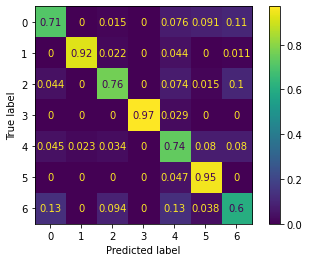

In [60]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

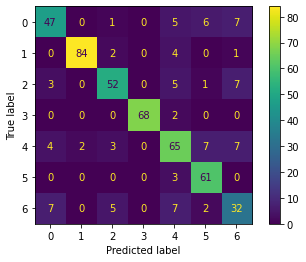

In [62]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [63]:
torch.save(torchModel, 'torchModel.pth')

In [33]:
for param_tensor in (torchModel.TorchModel.state_dict()):
    print(param_tensor, "\t", torchModel.TorchModel.state_dict()[param_tensor].size())

0.weight 	 torch.Size([256, 768])
0.bias 	 torch.Size([256])
3.weight 	 torch.Size([128, 256])
3.bias 	 torch.Size([128])
6.weight 	 torch.Size([7, 128])
6.bias 	 torch.Size([7])


In [34]:
torch.save(torchModel.TorchModel.state_dict(),'torchModel_state_dict.pth')

In [21]:
torchModel =  torch.load('torchModel.pth', map_location=torch.device('cuda'))

In [16]:

n_classes = 7
torchModel = TorchNLP(n_classes)
torchModel.TorchModel.load_state_dict(torch.load('torchModel_state_dict.pth'))

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [25]:
torchModel.eval()
torchModel.predict(X[:15])

array([5, 1, 5, 6, 4, 6, 5, 6, 6, 1, 6, 4, 4, 6, 2], dtype=int64)

In [24]:
Y[:15]

array([4, 6, 5, 4, 2, 6, 5, 4, 6, 4, 2, 6, 6, 6, 6], dtype=int64)

In [99]:

type(X)


pandas.core.series.Series

In [149]:
testing = pd.Series(data={'Beskrivning_Anonymized':'När kommer nästa tågtabell ut?'})


In [150]:
output = torchModel.predict(testing)
output


array([2], dtype=int64)

In [151]:
classes[output[0]]

'Fråga'

In [152]:
Y

array([1, 2, 6, ..., 1, 0, 4], dtype=int64)

In [130]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [42]:
#Evaluate loaded model on full dataset
mMiniBatcherFull = MiniBatcher(X[:50000], Y[:50000], batch_size=100)

In [ ]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherFull.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)
        print(mMiniBatcherFull.getBatchInfo())

batch: 1/500
batch: 2/500
batch: 3/500
batch: 4/500
batch: 5/500
batch: 6/500
batch: 7/500
batch: 8/500
batch: 9/500
batch: 10/500
batch: 11/500
batch: 12/500
batch: 13/500
batch: 14/500
batch: 15/500
batch: 16/500
batch: 17/500
batch: 18/500
batch: 19/500
batch: 20/500
batch: 21/500
batch: 22/500
batch: 23/500
batch: 24/500
batch: 25/500
batch: 26/500
batch: 27/500
batch: 28/500


In [ ]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [ ]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

In [44]:

list(range(Y_test.columns.shape[0]))

[0, 1, 2, 3, 4, 5, 6]